In [1]:
# import sys, numpy, math
import scipy.stats as scipystats
import matplotlib.pyplot as plt
import numpy as np
import numpy
import re
from scipy.stats import beta
import sys, os, math
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Deemed colorblind safe: http://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3
highConfColor     ='#1b9e77'
medConfColor      ='#7570b3'
lowConfColor      ='#d95f02'
unclassifiedColor ='black'

reference_dir = '../../../../HCC1395/HighConfidenceCalls/truth_v1.1/'

In [2]:
sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/')
sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/utilities')

import genomic_file_handlers as genome
from bedFileHandler import BedFile

callableLoci = BedFile('{}/BED/mergeBed.MajorityAlignersCallable.bed'.format(reference_dir))

In [3]:
truth_snv   = os.path.join(reference_dir, 'sSNV.MSDUKT.superSet.v1.2.vcf.gz' )
truth_indel = os.path.join(reference_dir, 'sINDEL.MDKT.superSet.v1.2.vcf.gz' )

ampliseq_snv_validation   = '/home/lethalfang/Documents/Bina/SMWG/AmpliSeqValidation/AmpliSeq.SNV.ValidationAnnotation.v1.2.tsv'
ampliseq_indel_validation = '/home/lethalfang/Documents/Bina/SMWG/AmpliSeqValidation/AmpliSeq.INDEL.ValidationAnnotation.v1.2.tsv'

In [4]:
def binom_interval(success, total, confint=0.95):
    quantile = (1 - confint) / 2
    lower = beta.ppf(quantile, success, total - success + 1)
    upper = beta.ppf(1 - quantile, success + 1, total - success)
    
    if math.isnan(lower): lower = 0
    if math.isnan(upper): upper = 1
        
    return (lower, upper)

In [5]:
def combo(N, n):
    return int( math.factorial(N)/( math.factorial(n) * math.factorial(N-n) ) )

def prob(N, n, vaf):
    return combo(N, n) * ( vaf**n ) * ( (1-vaf)**(N-n) )

def cdf(N, vaf):
    prob_i = []
    for i in range(N+1):
        prob_i.append( prob(N, i, vaf) )
        
    return np.cumsum( prob_i )

def conf_interval(N, vaf, conf=0.95):

    cdf_vector = cdf(N, vaf)
    
    outlier = (1-conf)/2
    lower = cdf_vector <= outlier
    upper = cdf_vector >= conf+outlier
    
    for i, bool_i in enumerate(lower):
        if not bool_i:
            lowerBound = i
            break
            
    for i, bool_i in enumerate(upper):
        if bool_i:
            upperBound = i
            break

    return lowerBound, upperBound

In [6]:
def R(x, y):
    assert len(x) == len(y)
    x1 = []
    y1 = []
    for x_i, y_i in zip(x,y):
        if math.isfinite(x_i) and math.isfinite(y_i):
            x1.append(x_i)
            y1.append(y_i)
            
    return scipystats.pearsonr(x1,y1)[0]

In [7]:
validationKeeper = {}

In [8]:
totalStats = { \
              'snv':  {'HighConf':     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                       'MedConf' :     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                       'LowConf' :     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                       'Unclassified': {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                      }, \
              'indel': {'HighConf':     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                        'MedConf' :     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                        'LowConf' :     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                        'Unclassified': {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                       }, \
             }

In [9]:
ampliseqSnvResults = {}
n_nonCallable = 0
with open(ampliseq_snv_validation) as ampliseqSnv, open('/tmp/ampliSeqCallables.tsv', 'w') as callable_redirect:
    
    ampliseq_line = ampliseqSnv.readline().rstrip()
    
    callable_redirect.write( ampliseq_line + '\n' )
    
    ampliseq_header     = ampliseq_line.split('\t')
    i_ampliseq_chrom    = ampliseq_header.index('CHROM')
    i_ampliseq_pos      = ampliseq_header.index('POS')
    i_ampliseq_ref      = ampliseq_header.index('REF')
    i_ampliseq_alt      = ampliseq_header.index('ALT')
    i_ampliseq_tVDP     = ampliseq_header.index('TumorVDP')
    i_ampliseq_tDP      = ampliseq_header.index('TumorDP')
    i_ampliseq_nVDP     = ampliseq_header.index('NormalVDP')
    i_ampliseq_nDP      = ampliseq_header.index('NormalDP')
    i_ampliseq_validate = ampliseq_header.index('VALIDATED')
    
    ampliseq_line = ampliseqSnv.readline().rstrip()
    while ampliseq_line:
        
        ampliseq_item = ampliseq_line.split('\t')
        
        variant_id = (ampliseq_item[i_ampliseq_chrom], int(ampliseq_item[i_ampliseq_pos]), ampliseq_item[i_ampliseq_ref], ampliseq_item[i_ampliseq_alt])
        
        if callableLoci.inRegion(variant_id[0], variant_id[1]):
        
            tVDP       = int( ampliseq_item[i_ampliseq_tVDP] )
            tDP        = int( ampliseq_item[i_ampliseq_tDP] )
            nVDP       = int( ampliseq_item[i_ampliseq_nVDP] )
            nDP        = int( ampliseq_item[i_ampliseq_nDP] )
            Validation = ampliseq_item[i_ampliseq_validate]

            ampliseqSnvResults[variant_id] = {'tVDP': tVDP, 'tDP': tDP, 'nVDP': nVDP, 'nDP': nDP, 'Validation': Validation}
            callable_redirect.write( ampliseq_line + '\n' )
            
        else:
            n_nonCallable += 1
        
        ampliseq_line = ampliseqSnv.readline().rstrip()
        
print('NonCallable positions =', n_nonCallable)

NonCallable positions = 95


In [10]:
print('Callable Positions =', len(ampliseqSnvResults) )

Callable Positions = 355


In [11]:
with genome.open_textfile(truth_snv) as goldSnv:
    
    gold_line = goldSnv.readline().rstrip()
    
    while gold_line.startswith('#'):
        gold_line = goldSnv.readline().rstrip()
        
    while gold_line:
        
        gold_vcf   = genome.Vcf_line(gold_line)
        variant_id = (gold_vcf.chromosome, gold_vcf.position, gold_vcf.refbase, gold_vcf.altbase)
        
        if variant_id in ampliseqSnvResults:
            
            TVAF     = float( gold_vcf.get_info_value('TVAF') )
            nPASSES  = int( gold_vcf.get_info_value('nPASSES') )
            nREJECTS = int( gold_vcf.get_info_value('nREJECTS') )
            neuE     = int( gold_vcf.get_info_value('NeuSomaticE') )
            
            if 'HighConf' in gold_vcf.filters:
                confLabel = 'HighConf'
            elif 'MedConf' in gold_vcf.filters:
                confLabel = 'MedConf'
            elif 'LowConf' in gold_vcf.filters:
                confLabel = 'LowConf'
            elif 'Unclassified' in gold_vcf.filters:
                confLabel = 'Unclassified'
                
            ampliseqSnvResults[variant_id].update({'TVAF': TVAF, 'confLabel': confLabel, 'nPASSES': nPASSES, 'neuE': neuE, 'nREJECTS': nREJECTS})
            
        gold_line = goldSnv.readline().rstrip()

In [12]:
validations     = []
validationTVAFs = []
goldTVAFs       = []
nPASSES         = []
neuE            = []
nREJECTS        = []
confLabels      = []

for variant_i in ampliseqSnvResults:
    
    confLabels.append( ampliseqSnvResults[variant_i]['confLabel'] )
    goldTVAFs.append( ampliseqSnvResults[variant_i]['TVAF'] )
    nPASSES.append( ampliseqSnvResults[variant_i]['nPASSES'] )
    neuE.append( ampliseqSnvResults[variant_i]['neuE'] )
    nREJECTS.append( ampliseqSnvResults[variant_i]['nREJECTS'] )
    
    validation_i = ampliseqSnvResults[variant_i]['Validation'].split(',')

    if variant_i not in validationKeeper:
        validationKeeper[variant_i] = {}
                
    if 'YES' in validation_i:
        validations.append( 'YES' )
        validationKeeper[variant_i] = {'confLabel': ampliseqSnvResults[variant_i]['confLabel'], 'ampliSeq': 'YES'}
    elif 'NO' in validation_i:
        validations.append( 'NO' )
        validationKeeper[variant_i] = {'confLabel': ampliseqSnvResults[variant_i]['confLabel'], 'ampliSeq': 'NO'}
    else:
        validations.append( 'UNKNOWN' )
        validationKeeper[variant_i] = {'confLabel': ampliseqSnvResults[variant_i]['confLabel'], 'ampliSeq': 'UNKNOWN'}

    try:
        validationTVAFs.append( ampliseqSnvResults[variant_i]['tVDP'] / ampliseqSnvResults[variant_i]['tDP'] )
    except ZeroDivisionError:
        validationTVAFs.append( math.nan )
        
validationTVAFs = numpy.array(validationTVAFs)
goldTVAFs       = numpy.array(goldTVAFs)
nPASSES         = numpy.array(nPASSES)
neuE            = numpy.array(neuE)
nREJECTS        = numpy.array(nREJECTS)
confLabels      = numpy.array(confLabels)
validations     = numpy.array(validations)

In [13]:
confLabels.shape, validations.shape, goldTVAFs.shape, nPASSES.shape, neuE.shape

((355,), (355,), (355,), (355,), (355,))

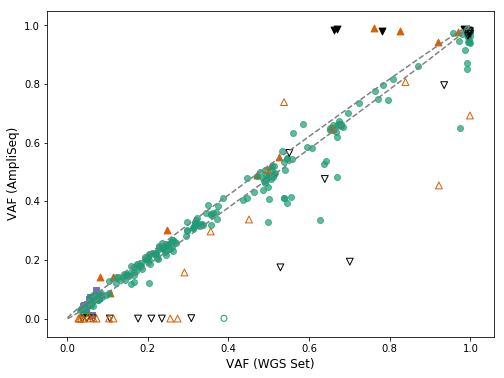

In [14]:
plt.figure(figsize=(8,6))

ms=36

plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], s=ms*1.3, color=unclassifiedColor, marker='v',)

plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ] , s=ms*1.3, color=lowConfColor, marker='^',  )

plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], s=ms, color=medConfColor, marker='s', )

plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], s=ms, color=highConfColor, marker='o', alpha=0.7 )

#plt.legend(('Unclassified', 'LowConf', 'MedConf',  'HighConf',  ), fontsize=12, loc='upper left')

plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], s=ms*1.3, color=unclassifiedColor, facecolors='none', marker='v')

plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], s=ms*1.3, color=lowConfColor, facecolors='none', marker='^')

plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], s=ms, color=medConfColor, facecolors='none', marker='s',)

plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], s=ms,  color=highConfColor, facecolors='none', marker='o')


# plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], s=ms*1.8, color=unclassifiedColor, marker='1',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], s=ms*1.8, color=lowConfColor, marker='2',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], s=ms*1.8,  color=medConfColor, marker='+',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], s=ms, color=highConfColor, marker='x',)


x_range     = []
lower_bound = []
upper_bound = []

vaf_i = 0.001
while vaf_i < 1:
    a, b = scipystats.binom.interval(0.95, 2000,vaf_i)
    x_range.append(vaf_i)
    lower_bound.append(a/2000)
    upper_bound.append(b/2000)
    vaf_i += 0.001
    
plt.plot(x_range, lower_bound, color='gray', linestyle = 'dashed')
plt.plot(x_range, upper_bound, color='gray', linestyle = 'dashed')

plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (AmpliSeq)', size=12)

plt.savefig('../Main_Figures/Fig_2d_ampliseq_cross_validation.pdf', bbox_inches='tight')

In [15]:
print( R(goldTVAFs[ confLabels=='HighConf'],     validationTVAFs[ confLabels=='HighConf' ]))
print( R(goldTVAFs[ confLabels=='MedConf'],      validationTVAFs[ confLabels=='MedConf' ]))
print( R(goldTVAFs[ confLabels=='LowConf'],      validationTVAFs[ confLabels=='LowConf' ]))
print( R(goldTVAFs[ confLabels=='Unclassified'], validationTVAFs[ confLabels=='Unclassified' ]))

0.9815461971044935
0.6552752059618416
0.8285266483876914
0.847680980390323


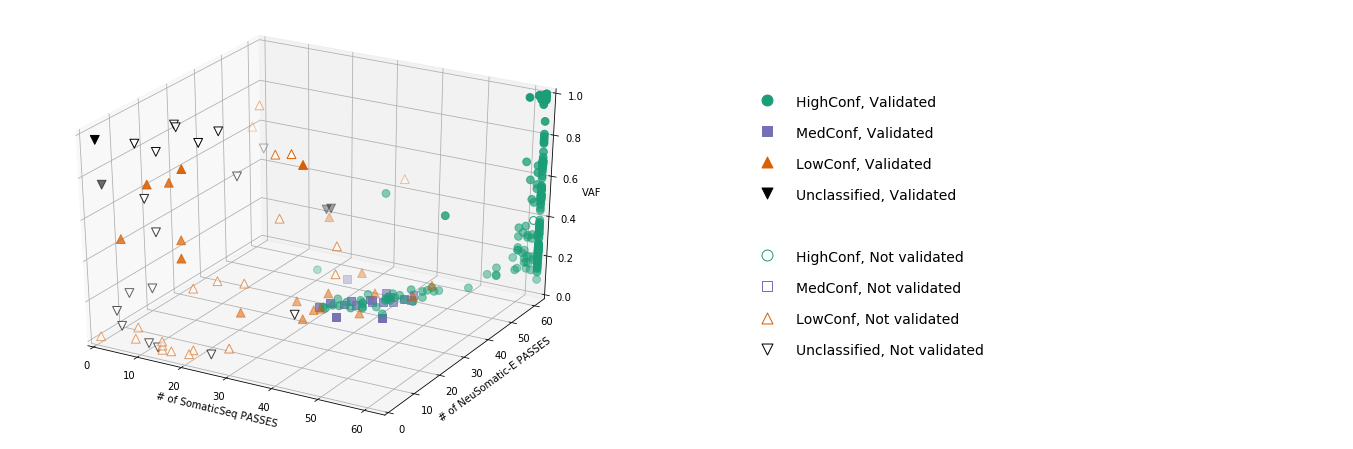

In [16]:
fig = plt.figure(figsize=(24,8))

ax = fig.add_subplot(121, projection='3d')

markersize = 60

ax.scatter(nPASSES[   np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], \
           neuE[      np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], \
           goldTVAFs[ np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], \
           color=highConfColor, s=markersize, marker='o' )

ax.scatter(nPASSES[   np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ],  \
           neuE[      np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], \
           goldTVAFs[ np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], \
           color=medConfColor, s=markersize, marker='s' )

ax.scatter(nPASSES[   np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ],  \
           neuE[      np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ], \
           goldTVAFs[ np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ], \
           color=lowConfColor, s=markersize*1.3, marker='^'  )

ax.scatter(nPASSES[   np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ],  \
           neuE[      np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], \
           goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], \
           color=unclassifiedColor, s=markersize*1.3, marker='v'  )

#ax.legend(('HighConf', 'MedConf', 'LowConf', 'Unclassified'))

ax.scatter(nPASSES[   np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], \
           neuE[      np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], \
           goldTVAFs[ np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], \
           color=highConfColor, s=markersize, facecolor='white', marker='o' )


ax.scatter(nPASSES[   np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], \
           neuE[      np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], \
           goldTVAFs[ np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], \
           color=medConfColor, s=markersize, facecolors='white', marker='s' )

ax.scatter(nPASSES[   np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], \
         neuE[      np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], \
         goldTVAFs[ np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], \
         color=lowConfColor, s=markersize*1.3, facecolors='white', marker='^' )


ax.scatter(nPASSES[  np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], \
          neuE[      np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], \
          goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], \
          color=unclassifiedColor, s=markersize*1.3, facecolors='white', marker='v' )



# ax.scatter(nPASSES[   np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], \
#            neuE[      np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], \
#            goldTVAFs[ np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], \
#            color=highConfColor, s=markersize, marker='x' )

# ax.scatter(nPASSES[   np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], \
#            neuE[      np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], \
#            goldTVAFs[ np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], \
#            color=medConfColor, s=markersize*1.8, marker='+' )

# ax.scatter(nPASSES[   np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], \
#            neuE[      np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], \
#            goldTVAFs[ np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], \
#            color=lowConfColor, s=markersize*1.8, marker='2' )

# ax.scatter(nPASSES[   np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], \
#            neuE[      np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], \
#            goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], \
#            color=unclassifiedColor, s=markersize*1.8, marker='1' )

ax.set_xlim(0, 63)
ax.set_ylim(0, 63)
ax.set_zlim(0, 1)

ax.set_xlabel('# of SomaticSeq PASSES')
ax.set_ylabel('# of NeuSomatic-E PASSES')
ax.set_zlabel('VAF')


ax = fig.add_subplot(122)


ax.scatter(0, 1-0.05*1, color=highConfColor,     s=markersize*2, marker='o')
ax.scatter(0, 1-0.05*2, color=medConfColor,      s=markersize*2, marker='s')
ax.scatter(0, 1-0.05*3, color=lowConfColor,      s=markersize*2, marker='^')
ax.scatter(0, 1-0.05*4, color=unclassifiedColor, s=markersize*2, marker='v')

ax.text(0.05, 1-0.05*1-0.01, 'HighConf, Validated', size=14)
ax.text(0.05, 1-0.05*2-0.01, 'MedConf, Validated', size=14)
ax.text(0.05, 1-0.05*3-0.01, 'LowConf, Validated', size=14)
ax.text(0.05, 1-0.05*4-0.01, 'Unclassified, Validated', size=14)


ax.scatter(0, 1-0.05*6, color=highConfColor,     facecolor='white', s=markersize*2, marker='o')
ax.scatter(0, 1-0.05*7, color=medConfColor,      facecolor='white', s=markersize*2, marker='s')
ax.scatter(0, 1-0.05*8, color=lowConfColor,      facecolor='white', s=markersize*2, marker='^')
ax.scatter(0, 1-0.05*9, color=unclassifiedColor, facecolor='white', s=markersize*2, marker='v')


ax.text(0.05, 1-0.05*6-0.01, 'HighConf, Not validated', size=14)
ax.text(0.05, 1-0.05*7-0.01, 'MedConf, Not validated', size=14)
ax.text(0.05, 1-0.05*8-0.01, 'LowConf, Not validated', size=14)
ax.text(0.05, 1-0.05*9-0.01, 'Unclassified, Not validated', size=14)

# ax.scatter(0, 1-0.05*11,  color=highConfColor,      s=markersize*3, marker='x')
# ax.scatter(0, 1-0.05*12, color=medConfColor,       s=markersize*3, marker='+')
# ax.scatter(0, 1-0.05*13, color=lowConfColor,       s=markersize*3, marker='2')
# ax.scatter(0, 1-0.05*14, color=unclassifiedColor,  s=markersize*3, marker='1')

# ax.text(0.05, 1-0.05*11-0.01, 'HighConf, uninterpretable', size=14)
# ax.text(0.05, 1-0.05*12-0.01, 'MedConf, uninterpretable', size=14)
# ax.text(0.05, 1-0.05*13-0.01, 'LowConf, uninterpretable', size=14)
# ax.text(0.05, 1-0.05*14-0.01, 'Unclassified, uninterpretable', size=14)


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)

ax.set_xlim((-0.05, 1))
ax.set_ylim((0.4, 1.1))

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_01c_somaticseq_vs_neusomatic_validation.pdf', bbox_inches='tight' )

In [17]:
for conf_i in 'HighConf', 'MedConf', 'LowConf', 'Unclassified':
    
    total_i = sum(confLabels==conf_i)
    total_validated = sum(np.all((validations=='YES', confLabels==conf_i), axis=0))
    total_invalidated = sum(np.all((validations=='NO', confLabels==conf_i), axis=0))
    validate_rate = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i
    
    totalStats['snv'][conf_i]['total']         += total_i
    totalStats['snv'][conf_i]['interpretable'] += (total_validated+total_invalidated)
    totalStats['snv'][conf_i]['validated']     += total_validated
    totalStats['snv'][conf_i]['notValidated']  += total_invalidated
    
    print('%g %s\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t%.1f%%' % (total_i, conf_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate, 100*interpretable_rate*validate_rate) )
    

for conf_i in 'HighConf', 'MedConf', 'LowConf', 'Unclassified':
    
    total_i = sum(confLabels==conf_i)
    total_validated = sum(np.all((validations=='YES', confLabels==conf_i), axis=0))
    total_invalidated = sum(np.all((validations=='NO', confLabels==conf_i), axis=0))
    validate_rate = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i
    
    print('%g\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (total_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate , total_validated, total_i, 100*(total_validated/total_i) ))

251 HighConf	(245/251) 97.6%	(244/245) 99.6%	97.2%
18 MedConf	(18/18) 100.0%	(18/18) 100.0%	100.0%
51 LowConf	(40/51) 78.4%	(19/40) 47.5%	37.3%
35 Unclassified	(22/35) 62.9%	(4/22) 18.2%	11.4%
251	(245/251) 97.6%	(244/245) 99.6%	(244/251) 97.2%
18	(18/18) 100.0%	(18/18) 100.0%	(18/18) 100.0%
51	(40/51) 78.4%	(19/40) 47.5%	(19/51) 37.3%
35	(22/35) 62.9%	(4/22) 18.2%	(4/35) 11.4%


In [18]:
print('HighConf SNV not validated:')
for variant_id in ampliseqSnvResults:
    if ampliseqSnvResults[variant_id]['confLabel'] == 'HighConf' and 'NO' in ampliseqSnvResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')
        
print('HighConf SNV Uninterpretable:')
for variant_id in ampliseqSnvResults:
    if ampliseqSnvResults[variant_id]['confLabel'] == 'HighConf' and 'UNKNOWN' in ampliseqSnvResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')

HighConf SNV not validated:
chr3	71328321	C	T
HighConf SNV Uninterpretable:
chr1	102718461	G	C
chr1	121380537	C	G
chr2	127740355	A	G
chr3	162063513	T	G
chr5	21904263	A	G
chr6	108864763	A	G


In [19]:
print('MedConf SNV not validated:')
for variant_id in ampliseqSnvResults:
    if ampliseqSnvResults[variant_id]['confLabel'] == 'MedConf' and 'NO' in ampliseqSnvResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')


MedConf SNV not validated:


In [20]:
print('Unclassified SNV potentially validated:')
for variant_id in ampliseqSnvResults:
    if ampliseqSnvResults[variant_id]['confLabel'] == 'Unclassified' and 'YES' in ampliseqSnvResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')

Unclassified SNV potentially validated:
chr3	117937789	C	T
chr8	107631542	G	A
chr8	107631545	T	G
chr11	24722179	T	G


In [21]:
print('LowConf SNV potentially validated:')
for variant_id in ampliseqSnvResults:
    if ampliseqSnvResults[variant_id]['confLabel'] == 'LowConf' and 'YES' in ampliseqSnvResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')

LowConf SNV potentially validated:
chr1	19209141	C	T
chr1	202463384	G	A
chr2	111227199	T	C
chr2	172657403	C	T
chr2	180173287	A	G
chr2	228407669	A	T
chr3	115867200	T	A
chr4	52550164	C	T
chr5	4254307	C	G
chr5	10794479	T	C
chr5	69090497	T	A
chr6	140911268	C	A
chr7	41496068	C	T
chr13	40663213	A	T
chr13	97463015	T	G
chr16	17203210	C	G
chr19	32811570	C	T
chr19	35488730	A	C
chr19	55768995	C	A


In [22]:
ampliseqIndelResults = {}
n_NonCallable = 0
with open(ampliseq_indel_validation) as ampliseqIndel:
    
    ampliseq_line = ampliseqIndel.readline().rstrip()
    
    ampliseq_header     = ampliseq_line.split('\t')
    i_ampliseq_chrom    = ampliseq_header.index('CHROM')
    i_ampliseq_pos      = ampliseq_header.index('POS')
    i_ampliseq_ref      = ampliseq_header.index('REF')
    i_ampliseq_alt      = ampliseq_header.index('ALT')
    i_ampliseq_tVDP     = ampliseq_header.index('TumorVDP')
    i_ampliseq_tDP      = ampliseq_header.index('TumorDP')
    i_ampliseq_nVDP     = ampliseq_header.index('NormalVDP')
    i_ampliseq_nDP      = ampliseq_header.index('NormalDP')
    i_ampliseq_validate = ampliseq_header.index('VALIDATED')
    
    ampliseq_line = ampliseqIndel.readline().rstrip()
    while ampliseq_line:
        
        ampliseq_item = ampliseq_line.split('\t')
        
        variant_id = (ampliseq_item[i_ampliseq_chrom], int(ampliseq_item[i_ampliseq_pos]), ampliseq_item[i_ampliseq_ref], ampliseq_item[i_ampliseq_alt])
        
        if callableLoci.inRegion(variant_id[0], variant_id[1]):
            tVDP       = int( ampliseq_item[i_ampliseq_tVDP] )
            tDP        = int( ampliseq_item[i_ampliseq_tDP] )
            nVDP       = int( ampliseq_item[i_ampliseq_nVDP] )
            nDP        = int( ampliseq_item[i_ampliseq_nDP] )
            Validation = ampliseq_item[i_ampliseq_validate]

            ampliseqIndelResults[variant_id] = {'tVDP': tVDP, 'tDP': tDP, 'nVDP': nVDP, 'nDP': nDP, 'Validation': Validation}
        else:
            n_NonCallable += 1
        
        ampliseq_line = ampliseqIndel.readline().rstrip()
        
print('NonCallable Positions =', n_NonCallable)

NonCallable Positions = 0


In [23]:
with genome.open_textfile(truth_indel) as goldIndel:
    
    gold_line = goldIndel.readline().rstrip()
    
    while gold_line.startswith('#'):
        gold_line = goldIndel.readline().rstrip()
    
    while gold_line:
        
        gold_vcf   = genome.Vcf_line(gold_line)
        variant_id = (gold_vcf.chromosome, gold_vcf.position, gold_vcf.refbase, gold_vcf.altbase)
        
        if variant_id in ampliseqIndelResults:
            
            TVAF     = float( gold_vcf.get_info_value('TVAF') )
            nPASSES  = int( gold_vcf.get_info_value('nPASSES') )
            nREJECTS = int( gold_vcf.get_info_value('nREJECTS') )
            
            if 'HighConf' in gold_vcf.filters:
                confLabel = 'HighConf'
            elif 'MedConf' in gold_vcf.filters:
                confLabel = 'MedConf'
            elif 'LowConf' in gold_vcf.filters:
                confLabel = 'LowConf'
            elif 'Unclassified' in gold_vcf.filters:
                confLabel = 'Unclassified'
                
            ampliseqIndelResults[variant_id].update({'TVAF': TVAF, 'confLabel': confLabel, 'nPASSES': nPASSES, 'nREJECTS': nREJECTS})
        
        gold_line = goldIndel.readline().rstrip()

In [24]:
validations     = []
validationTVAFs = []
goldTVAFs       = []
nPASSES         = []
nREJECTS        = []
confLabels      = []
for variant_i in ampliseqIndelResults:
    
    confLabels.append( ampliseqIndelResults[variant_i]['confLabel'] )
    goldTVAFs.append( ampliseqIndelResults[variant_i]['TVAF'] )
    nPASSES.append( ampliseqIndelResults[variant_i]['nPASSES'] )
    nREJECTS.append( ampliseqIndelResults[variant_i]['nREJECTS'] )
    
    validation_i = ampliseqIndelResults[variant_i]['Validation'].split(',')

    if variant_i not in validationKeeper:
        validationKeeper[variant_i] = {}
                
    if 'YES' in validation_i:
        validations.append( 'YES' )
        validationKeeper[variant_i] = {'confLabel': ampliseqIndelResults[variant_i]['confLabel'], 'ampliSeq': 'YES'}
    elif 'NO' in validation_i:
        validations.append( 'NO' )
        validationKeeper[variant_i] = {'confLabel': ampliseqIndelResults[variant_i]['confLabel'], 'ampliSeq': 'NO'}
    elif 'UNKNOWN' in validation_i:
        validations.append( 'UNKNOWN' )
        validationKeeper[variant_i] = {'confLabel': ampliseqIndelResults[variant_i]['confLabel'], 'ampliSeq': 'UNKNOWN'}
    
    try:
        validationTVAFs.append( ampliseqIndelResults[variant_i]['tVDP'] / ampliseqIndelResults[variant_i]['tDP'] )
    except ZeroDivisionError:
        validationTVAFs.append( math.nan )
        
validationTVAFs = numpy.array(validationTVAFs)
goldTVAFs       = numpy.array(goldTVAFs)
nPASSES         = numpy.array(nPASSES)
nREJECTS        = numpy.array(nREJECTS)
confLabels      = numpy.array(confLabels)
validations     = numpy.array(validations)

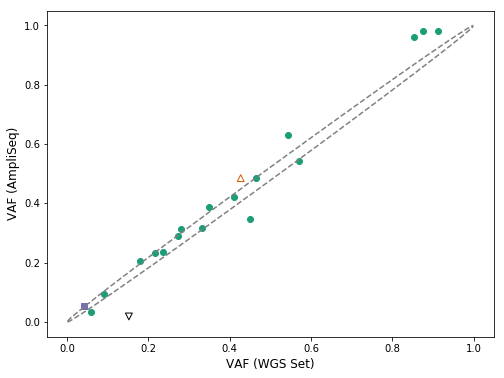

In [25]:
plt.figure(figsize=(8,6))

ms=36

plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], s=ms*1.3, color=unclassifiedColor, marker='v',)

plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ] , s=ms*1.3, color=lowConfColor, marker='^',  )

plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], s=ms, color=medConfColor, marker='s', )

plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], s=ms, color=highConfColor, marker='o', )

#plt.legend(('Unclassified', 'LowConf', 'MedConf',  'HighConf',  ), fontsize=12, loc='upper left')

plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], s=ms*1.3, color=unclassifiedColor, facecolors='none', marker='v')

plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], s=ms*1.3, color=lowConfColor, facecolors='none', marker='^')

plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], s=ms, color=medConfColor, facecolors='none', marker='s',)

plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], s=ms,  color=highConfColor, facecolors='none', marker='o')


# plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], s=ms*1.8, color=unclassifiedColor, marker='1',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], s=ms*1.8, color=lowConfColor, marker='2',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], s=ms*1.8,  color=medConfColor, marker='+',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], s=ms, color=highConfColor, marker='x',)


x_range     = []
lower_bound = []
upper_bound = []

vaf_i = 0.001
while vaf_i < 1:
    a, b = scipystats.binom.interval(0.95, 2000,vaf_i)
    x_range.append(vaf_i)
    lower_bound.append(a/2000)
    upper_bound.append(b/2000)
    vaf_i += 0.001
    
plt.plot(x_range, lower_bound, color='gray', linestyle = 'dashed')
plt.plot(x_range, upper_bound, color='gray', linestyle = 'dashed')

plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (AmpliSeq)', size=12)

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_03a_ampliseq_indel_cross_validation.pdf', bbox_inches='tight')

In [26]:
print( R(goldTVAFs[ confLabels=='HighConf'],  validationTVAFs[ confLabels=='HighConf' ]) )

0.9892277353554156


In [27]:
len(goldTVAFs[ confLabels=='Unclassified']), len(validationTVAFs[ confLabels=='Unclassified']), 

(2, 2)

In [28]:
for conf_i in 'HighConf', 'MedConf', 'LowConf', 'Unclassified':
    
    total_i = sum(confLabels==conf_i)
    total_validated = sum(np.all((validations=='YES', confLabels==conf_i), axis=0))
    total_invalidated = sum(np.all((validations=='NO', confLabels==conf_i), axis=0))
    validate_rate = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i
    
    totalStats['indel'][conf_i]['total']         += total_i
    totalStats['indel'][conf_i]['interpretable'] += (total_validated+total_invalidated)
    totalStats['indel'][conf_i]['validated']     += total_validated
    totalStats['indel'][conf_i]['notValidated']  += total_invalidated

    print('%g %s\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t%.1f%%' % (total_i, conf_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate, 100*interpretable_rate*validate_rate) )
    
for conf_i in 'HighConf', 'MedConf', 'LowConf', 'Unclassified':
    
    total_i = sum(confLabels==conf_i)
    total_validated = sum(np.all((validations=='YES', confLabels==conf_i), axis=0))
    total_invalidated = sum(np.all((validations=='NO', confLabels==conf_i), axis=0))
    validate_rate = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i
    
    print('%g\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (total_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate, total_validated, total_i, 100*(total_validated/total_i)) )

17 HighConf	(17/17) 100.0%	(17/17) 100.0%	100.0%
1 MedConf	(1/1) 100.0%	(1/1) 100.0%	100.0%
1 LowConf	(1/1) 100.0%	(0/1) 0.0%	0.0%
2 Unclassified	(1/2) 50.0%	(0/1) 0.0%	0.0%
17	(17/17) 100.0%	(17/17) 100.0%	(17/17) 100.0%
1	(1/1) 100.0%	(1/1) 100.0%	(1/1) 100.0%
1	(1/1) 100.0%	(0/1) 0.0%	(0/1) 0.0%
2	(1/2) 50.0%	(0/1) 0.0%	(0/2) 0.0%


In [29]:
print('HighConf INDEL not validated:')
for variant_id in ampliseqIndelResults:
    if ampliseqIndelResults[variant_id]['confLabel'] == 'HighConf' and 'NO' in ampliseqIndelResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')
        
print('HighConf INDEL Uninterpretable:')
for variant_id in ampliseqIndelResults:
    if ampliseqIndelResults[variant_id]['confLabel'] == 'HighConf' and 'UNKNOWN' in ampliseqIndelResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')

HighConf INDEL not validated:
HighConf INDEL Uninterpretable:


In [30]:
print('Unclassified INDEL potentially validated:')
for variant_id in ampliseqIndelResults:
    if ampliseqIndelResults[variant_id]['confLabel'] == 'Unclassified' and 'YES' in ampliseqIndelResults[variant_id]['Validation'].split(','):
        print(variant_id)

Unclassified INDEL potentially validated:


In [31]:
ion_snv_validation   = '/home/lethalfang/Documents/Bina/SMWG/IonTorrentValidation/v1.1.IonTorrentInfoForSNV.tsv'
ion_indel_validation = '/home/lethalfang/Documents/Bina/SMWG/IonTorrentValidation/v1.1.IonTorrentInfoForINDEL.tsv'

In [32]:
ionSnvResults = {}
with open(ion_snv_validation) as snv:
    
    line_i = snv.readline().rstrip()
    header = line_i.split('\t')
    
    i_ID             = header.index('ID')
    i_normalDP       = header.index('NORMAL_bam_DP')
    i_normalForVarDP = header.index('NORMAL_bam_ALT_FOR')
    i_normalRevVarDP = header.index('NORMAL_bam_ALT_REV')
    i_tumorDP        = header.index('TUMOR_bam_DP')
    i_tumorForVarDP  = header.index('TUMOR_bam_ALT_FOR')
    i_tumorRevVarDP  = header.index('TUMOR_bam_ALT_REV')
    
    line_i = snv.readline().rstrip()
    
    while line_i:
        
        item       = line_i.split('\t')
        variant_id = ( item[0], int(item[1]), item[3], item[4] )
        
        if callableLoci.inRegion(variant_id[0], variant_id[1]):
            t_dp  = int(item[i_tumorDP])
            t_vdp = int(item[i_tumorForVarDP]) + int(item[i_tumorRevVarDP])
            n_dp  = int(item[i_normalDP])
            n_vdp = int(item[i_normalForVarDP]) + int(item[i_normalRevVarDP])
        
            goldvaf = float( re.search(r'TVAF=(1|0\.[0-9]+)', item[i_ID]).groups()[0] )
        
            try:
                ionTVAF = t_vdp / t_dp
            except ZeroDivisionError:
                ionTVAF = math.nan

            ionSnvResults[variant_id] = {'tDP': t_dp, 'tVDP': t_vdp, 'nDP': n_dp, 'nVDP': n_vdp, 'ionTVAF': ionTVAF}
        
            # Simple rule to decide if validated or not:
            if t_dp >= 8 and n_dp >= 10:
            
                # VALIDATED. If tumor DP low, at least 2 variants. If tumor DP>50, VAF at least 4% (need more than 2).
                if (t_vdp >=2) and (t_vdp/t_dp > 10*n_vdp/n_dp):
                
                    ionSnvResults[variant_id].update({ 'Validation': 'YES' })
                        
                # INVALIDATED (Germline Signal)
                elif n_dp >=20 and (n_vdp > 0.1*n_dp):
                
                    ionSnvResults[variant_id].update({ 'Validation': 'NO' })

                # INVALIDATED (NO variant signal): Expect variant DP >= 5, but gets zero.
                elif t_vdp == 0 and t_dp*goldvaf >= 5:

                    ionSnvResults[variant_id].update({ 'Validation': 'NO' })

            # UNKNOWN
                else:
                    ionSnvResults[variant_id].update({ 'Validation': 'UNKNOWN' })

            # UNKNOWN  
            else:
                ionSnvResults[variant_id].update({ 'Validation': 'UNKNOWN' })
        
        line_i = snv.readline().rstrip()

In [33]:
with genome.open_textfile(truth_snv) as goldSnv:
    
    gold_line = goldSnv.readline().rstrip()
    
    while gold_line.startswith('#'):
        gold_line = goldSnv.readline().rstrip()
        
    while gold_line:
        
        gold_vcf   = genome.Vcf_line(gold_line)
        variant_id = (gold_vcf.chromosome, gold_vcf.position, gold_vcf.refbase, gold_vcf.altbase)
        
        if variant_id in ionSnvResults:
            
            TVAF     = float( gold_vcf.get_info_value('TVAF') )
            nPASSES  = int( gold_vcf.get_info_value('nPASSES') )
            try:
                nREJECTS = int( gold_vcf.get_info_value('nREJECTS') )
            except ValueError:
                nREJECTS = math.nan
            
            if 'HighConf' in gold_vcf.filters:
                confLabel = 'HighConf'
            elif 'MedConf' in gold_vcf.filters:
                confLabel = 'MedConf'
            elif 'LowConf' in gold_vcf.filters:
                confLabel = 'LowConf'
            elif 'Unclassified' in gold_vcf.filters:
                confLabel = 'Unclassified'
                
            ionSnvResults[variant_id].update({'TVAF': TVAF, 'confLabel': confLabel, 'nPASSES': nPASSES, 'nREJECTS': nREJECTS})
        
        gold_line = goldSnv.readline().rstrip()

In [34]:
validations     = []
validationTVAFs = []
goldTVAFs       = []
nPASSES         = []
nREJECTS        = []
confLabels      = []
for variant_i in ionSnvResults:
    
    try:
        confLabels.append( ionSnvResults[variant_i]['confLabel'] )
    except KeyError:
        print(variant_i)
    goldTVAFs.append( ionSnvResults[variant_i]['TVAF'] )
    nPASSES.append( ionSnvResults[variant_i]['nPASSES'] )
    nREJECTS.append( ionSnvResults[variant_i]['nREJECTS'] )
    
    validation_i = ionSnvResults[variant_i]['Validation'].split(',')
    
    if variant_i not in validationKeeper:
        validationKeeper[variant_i] = {}
                
    if 'YES' in validation_i:
        validations.append( 'YES' )
        validationKeeper[variant_i] = {'confLabel': ionSnvResults[variant_i]['confLabel'], 'ionTorrent': 'YES'}
    elif 'NO' in validation_i:
        validations.append( 'NO' )
        validationKeeper[variant_i] = {'confLabel': ionSnvResults[variant_i]['confLabel'], 'ionTorrent': 'NO'}
    elif 'UNKNOWN' in validation_i:
        validations.append( 'UNKNOWN' )
        validationKeeper[variant_i] = {'confLabel': ionSnvResults[variant_i]['confLabel'], 'ionTorrent': 'UNKNOWN'}
    
    try:
        validationTVAFs.append( ionSnvResults[variant_i]['tVDP'] / ionSnvResults[variant_i]['tDP'] )
    except ZeroDivisionError:
        validationTVAFs.append( math.nan )
        
validationTVAFs = numpy.array(validationTVAFs)
goldTVAFs       = numpy.array(goldTVAFs)
nPASSES         = numpy.array(nPASSES)
nREJECTS        = numpy.array(nREJECTS)
confLabels      = numpy.array(confLabels)
validations     = numpy.array(validations)

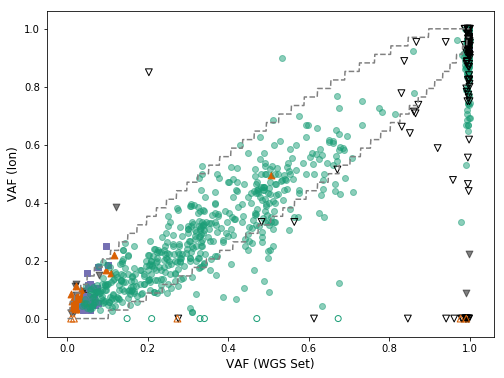

In [35]:
plt.figure(figsize=(8,6))

ms=36

# plt.scatter(0,1, s=ms*1.3, color=unclassifiedColor, marker='v' , facecolors='none')
# plt.scatter(0,1, s=ms*1.3, color=lowConfColor,      marker='^' , facecolors='none')
# plt.scatter(0,1, s=ms, color=medConfColor,      marker='s' , facecolors='none')
# plt.scatter(0,1, s=ms, color=highConfColor,     marker='o' , facecolors='none')
# plt.scatter(0,1, s=ms, color='white')

# plt.legend(('Unclassified', 'LowConf', 'MedConf',  'HighConf',  ), fontsize=12, loc='upper left')


plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], s=ms*1.3, color=unclassifiedColor, marker='v', alpha=0.5)

plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ] , s=ms*1.3, color=lowConfColor, marker='^',  )

plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], s=ms, color=medConfColor, marker='s', )

plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], s=ms, color=highConfColor, marker='o', alpha=0.5)


plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], s=ms*1.3, color=unclassifiedColor, facecolors='none', marker='v')

plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], s=ms*1.3, color=lowConfColor, facecolors='none', marker='^')

plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], s=ms, color=medConfColor, facecolors='none', marker='s',)

plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], s=ms,  color=highConfColor, facecolors='none', marker='o')


# plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], s=ms, color=highConfColor, marker='x',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], s=ms*1.8,  color=medConfColor, marker='+',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], s=ms*1.8, color=lowConfColor, marker='2',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], s=ms*1.8, color=unclassifiedColor, marker='1',)



x_range     = []
lower_bound = []
upper_bound = []

vaf_i = 0.001
while vaf_i < 1:
    a, b = scipystats.binom.interval(0.95, 34,vaf_i)
    x_range.append(vaf_i)
    lower_bound.append(a/34)
    upper_bound.append(b/34)
    vaf_i += 0.001
    
plt.plot(x_range, lower_bound, color='gray', linestyle = 'dashed')
plt.plot(x_range, upper_bound, color='gray', linestyle = 'dashed')

plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (Ion)', size=12)

plt.savefig('../Main_Figures/Fig_2e_ion_cross_validation.pdf', bbox_inches='tight')

In [36]:
print( R(goldTVAFs[ confLabels=='HighConf'],  validationTVAFs[ confLabels=='HighConf' ]) )
print( R(goldTVAFs[ confLabels=='MedConf'],  validationTVAFs[ confLabels=='MedConf' ]) )
print( R(goldTVAFs[ confLabels=='LowConf'],  validationTVAFs[ confLabels=='LowConf' ]) )
print( R(goldTVAFs[ confLabels=='Unclassified'],  validationTVAFs[ confLabels=='Unclassified' ]) )

0.9299686398715011
0.923020323170705
0.2705409802086581
0.8580828669205971


In [37]:
for conf_i in 'HighConf', 'MedConf', 'LowConf', 'Unclassified':
    
    total_i            = sum(confLabels==conf_i)
    total_validated    = sum(np.all((validations=='YES', confLabels==conf_i), axis=0))
    total_invalidated  = sum(np.all((validations=='NO', confLabels==conf_i), axis=0))
    validate_rate      = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i

    totalStats['snv'][conf_i]['total']         += total_i
    totalStats['snv'][conf_i]['interpretable'] += (total_validated+total_invalidated)
    totalStats['snv'][conf_i]['validated']     += total_validated
    totalStats['snv'][conf_i]['notValidated']  += total_invalidated
    
    print('%g %s\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t%.1f%%' % (total_i, conf_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate, 100*interpretable_rate*validate_rate) )
    
for conf_i in 'HighConf', 'MedConf', 'LowConf', 'Unclassified':
    
    total_i            = sum(confLabels==conf_i)
    total_validated    = sum(np.all((validations=='YES', confLabels==conf_i), axis=0))
    total_invalidated  = sum(np.all((validations=='NO', confLabels==conf_i), axis=0))
    validate_rate      = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i
    
    print('%g\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (total_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate , total_validated, total_i, 100*(total_validated/total_i) ))

713 HighConf	(636/713) 89.2%	(630/636) 99.1%	88.4%
50 MedConf	(27/50) 54.0%	(27/27) 100.0%	54.0%
216 LowConf	(38/216) 17.6%	(33/38) 86.8%	15.3%
519 Unclassified	(110/519) 21.2%	(17/110) 15.5%	3.3%
713	(636/713) 89.2%	(630/636) 99.1%	(630/713) 88.4%
50	(27/50) 54.0%	(27/27) 100.0%	(27/50) 54.0%
216	(38/216) 17.6%	(33/38) 86.8%	(33/216) 15.3%
519	(110/519) 21.2%	(17/110) 15.5%	(17/519) 3.3%


In [38]:
print('HighConf SNV not validated:')
for variant_id in ionSnvResults:
    if ionSnvResults[variant_id]['confLabel'] == 'HighConf' and 'NO' in ionSnvResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')
        
print('HighConf SNV Uninterpretable:')
for variant_id in ionSnvResults:
    if ionSnvResults[variant_id]['confLabel'] == 'HighConf' and 'UNKNOWN' in ionSnvResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')

HighConf SNV not validated:
chr2	97211773	C	T
chr5	141332648	C	T
chr6	167208829	G	C
chr9	92885181	T	A
chr10	5882953	G	C
chr15	28815512	G	A
HighConf SNV Uninterpretable:
chr1	12001578	C	T
chr1	33743669	G	C
chr1	36176447	G	A
chr1	107770629	G	A
chr1	116584988	C	A
chr1	168300462	C	A
chr1	179813632	G	A
chr1	179813633	A	C
chr1	228307554	G	A
chr2	171855929	A	C
chr2	232329722	G	C
chr3	38752270	T	A
chr3	72997533	T	A
chr3	126498142	G	A
chr3	160448892	G	T
chr4	343934	C	T
chr4	442068	T	C
chr4	1740801	G	A
chr4	15519875	G	C
chr4	38943498	C	T
chr4	41646299	C	G
chr4	128098247	G	A
chr4	153622026	G	C
chr5	103104741	G	A
chr5	178932532	G	T
chr5	179733119	C	G
chr7	4909705	G	C
chr7	30883201	C	G
chr7	47833095	G	A
chr7	143390060	G	A
chr7	151115391	G	A
chr7	151366935	C	T
chr8	94543935	G	A
chr8	132100024	A	G
chr8	142511012	C	G
chr9	32450033	G	A
chr9	99826856	C	A
chr9	127445102	A	G
chr9	136994920	C	T
chr9	138120682	G	A
chr10	13740500	G	A
chr10	27037173	G	A
chr10	80609406	C	T
chr10	104046624	G	C
chr11	6410518	C	T

In [39]:
print('LowConf calls potentially validated:')
for variant_id in ionSnvResults:
    if ionSnvResults[variant_id]['confLabel'] == 'LowConf' and 'YES' in ionSnvResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')

LowConf calls potentially validated:
chr1	29053344	C	T
chr1	33617572	C	G
chr1	39452086	T	C
chr1	116579677	C	A
chr1	201321924	G	A
chr1	201321925	G	A
chr1	227655016	A	C
chr2	178607249	A	G
chr2	184936649	G	T
chr3	129440343	T	A
chr3	134551984	T	C
chr6	118651323	T	C
chr7	102465725	G	A
chr7	107767595	C	T
chr7	111740124	C	G
chr7	128856685	G	A
chr9	94301165	A	C
chr10	101521626	C	T
chr11	72711404	C	T
chr12	18563498	A	G
chr13	23889342	T	A
chr13	49792519	C	G
chr14	24160167	G	C
chr14	50913150	G	A
chr14	77321401	A	G
chr15	68290629	G	C
chr17	7592599	T	G
chr17	50171511	C	G
chr17	81435567	T	C
chr19	6677931	T	C
chr19	18258430	C	T
chr19	35488730	A	C
chr19	58279880	T	A


In [40]:
print('Unclassified calls potentially validated:')
for variant_id in ionSnvResults:
    if ionSnvResults[variant_id]['confLabel'] == 'Unclassified' and 'YES' in ionSnvResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], sep='\t')

Unclassified calls potentially validated:
chr2	3499139	G	C
chr3	156979303	T	G
chr3	195784077	G	T
chr6	116626747	T	A
chr7	128677593	G	A
chr8	23368194	A	T
chr8	23368207	C	T
chr10	77828865	C	T
chr10	122585191	C	T
chr11	44903400	C	G
chr11	69650998	T	C
chr12	109407973	C	T
chr16	4114370	A	G
chr17	8575269	A	G
chr19	8969831	G	A
chr19	41253729	C	T
chr19	43184852	G	A


In [41]:
ionIndelResults = {}
with open(ion_indel_validation) as snv:
    
    line_i = snv.readline().rstrip()
    header = line_i.split('\t')
    
    i_ID             = header.index('ID')
    i_normalDP       = header.index('NORMAL_bam_DP')
    i_normalForVarDP = header.index('NORMAL_bam_ALT_FOR')
    i_normalRevVarDP = header.index('NORMAL_bam_ALT_REV')
    i_tumorDP        = header.index('TUMOR_bam_DP')
    i_tumorForVarDP  = header.index('TUMOR_bam_ALT_FOR')
    i_tumorRevVarDP  = header.index('TUMOR_bam_ALT_REV')
    
    line_i = snv.readline().rstrip()
    
    while line_i:
        
        item       = line_i.split('\t')
        variant_id = ( item[0], int(item[1]), item[3], item[4] )
        
        if callableLoci.inRegion(variant_id[0], variant_id[1]):
            t_dp  = int(item[i_tumorDP])
            t_vdp = int(item[i_tumorForVarDP]) + int(item[i_tumorRevVarDP])
            n_dp  = int(item[i_normalDP])
            n_vdp = int(item[i_normalForVarDP]) + int(item[i_normalRevVarDP])
        
            goldvaf = float( re.search(r'TVAF=(1|0\.[0-9]+)', item[i_ID]).groups()[0] )
        
            try:
                ionTVAF = t_vdp / t_dp
            except ZeroDivisionError:
                ionTVAF = math.nan

            ionIndelResults[variant_id] = {'tDP': t_dp, 'tVDP': t_vdp, 'nDP': n_dp, 'nVDP': n_vdp, 'ionTVAF': ionTVAF}
        
            # Simple rule to decide if validated or not:
            if t_dp >= 8 and n_dp >= 10:
            
                # VALIDATED. If tumor DP low, at least 2 variants. If tumor DP>50, VAF at least 4% (need more than 2).
                if (t_vdp >=2) and (t_vdp/t_dp > 10*n_vdp/n_dp):
                
                    ionIndelResults[variant_id].update({ 'Validation': 'YES' })
                        
                # INVALIDATED (Germline Signal)
                elif n_dp >=20 and (n_vdp > 0.1*n_dp):
                
                    ionIndelResults[variant_id].update({ 'Validation': 'NO' })

                # INVALIDATED (NO variant signal): Expect variant DP >= 5, but gets zero.
                elif t_vdp == 0 and t_dp*goldvaf >= 5:

                    ionIndelResults[variant_id].update({ 'Validation': 'NO' })

                # UNKNOWN
                else:
                    ionIndelResults[variant_id].update({ 'Validation': 'UNKNOWN' })

            # UNKNOWN  
            else:
                ionIndelResults[variant_id].update({ 'Validation': 'UNKNOWN' })
        
        line_i = snv.readline().rstrip()

In [42]:
with genome.open_textfile(truth_indel) as goldSnv:
    
    gold_line = goldSnv.readline().rstrip()
    
    while gold_line.startswith('#'):
        gold_line = goldSnv.readline().rstrip()
        
    while gold_line:
        
        gold_vcf   = genome.Vcf_line(gold_line)
        variant_id = (gold_vcf.chromosome, gold_vcf.position, gold_vcf.refbase, gold_vcf.altbase)
        
        if variant_id in ionIndelResults:
            
            TVAF     = float( gold_vcf.get_info_value('TVAF') )
            nPASSES  = int( gold_vcf.get_info_value('nPASSES') )
            try:
                nREJECTS = int( gold_vcf.get_info_value('nREJECTS') )
            except ValueError:
                nREJECTS = math.nan
            
            if 'HighConf' in gold_vcf.filters:
                confLabel = 'HighConf'
            elif 'MedConf' in gold_vcf.filters:
                confLabel = 'MedConf'
            elif 'LowConf' in gold_vcf.filters:
                confLabel = 'LowConf'
            elif 'Unclassified' in gold_vcf.filters:
                confLabel = 'Unclassified'
                
            ionIndelResults[variant_id].update({'TVAF': TVAF, 'confLabel': confLabel, 'nPASSES': nPASSES, 'nREJECTS': nREJECTS})
        
        gold_line = goldSnv.readline().rstrip()

In [43]:
validations     = []
validationTVAFs = []
goldTVAFs       = []
nPASSES         = []
nREJECTS        = []
confLabels      = []
for variant_i in ionIndelResults:
    
    try:
        confLabels.append( ionIndelResults[variant_i]['confLabel'] )
    except KeyError:
        print(variant_i)
    goldTVAFs.append( ionIndelResults[variant_i]['TVAF'] )
    nPASSES.append( ionIndelResults[variant_i]['nPASSES'] )
    nREJECTS.append( ionIndelResults[variant_i]['nREJECTS'] )
    
    validation_i = ionIndelResults[variant_i]['Validation'].split(',')
    
    if variant_i not in validationKeeper:
        validationKeeper[variant_i] = {}
                
    if 'YES' in validation_i:
        validations.append( 'YES' )
        validationKeeper[variant_i] = {'confLabel': ionIndelResults[variant_i]['confLabel'], 'ionTorrent': 'YES'}
    elif 'NO' in validation_i:
        validations.append( 'NO' )
        validationKeeper[variant_i] = {'confLabel': ionIndelResults[variant_i]['confLabel'], 'ionTorrent': 'NO'}
    elif 'UNKNOWN' in validation_i:
        validations.append( 'UNKNOWN' )
        validationKeeper[variant_i] = {'confLabel': ionIndelResults[variant_i]['confLabel'], 'ionTorrent': 'UNKNOWN'}
    
    try:
        validationTVAFs.append( ionIndelResults[variant_i]['tVDP'] / ionIndelResults[variant_i]['tDP'] )
    except ZeroDivisionError:
        validationTVAFs.append( math.nan )
        
validationTVAFs = numpy.array(validationTVAFs)
goldTVAFs       = numpy.array(goldTVAFs)
nPASSES         = numpy.array(nPASSES)
nREJECTS        = numpy.array(nREJECTS)
confLabels      = numpy.array(confLabels)
validations     = numpy.array(validations)

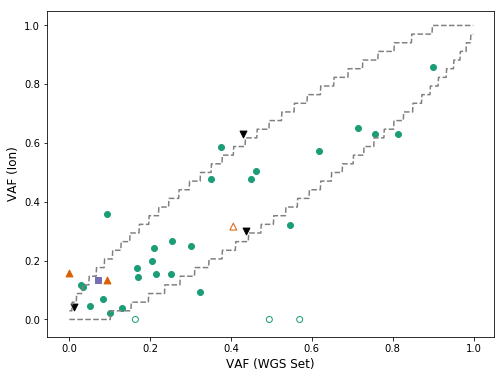

In [44]:
plt.figure(figsize=(8,6))

ms=36

# plt.scatter(0,1, s=ms*1.3, color=unclassifiedColor, marker='v' , facecolors='none')
# plt.scatter(0,1, s=ms*1.3, color=lowConfColor,      marker='^' , facecolors='none')
# plt.scatter(0,1, s=ms, color=medConfColor,      marker='s' , facecolors='none')
# plt.scatter(0,1, s=ms, color=highConfColor,     marker='o' , facecolors='none')
# plt.scatter(0,1, s=ms, color='white')

# plt.legend(('Unclassified', 'LowConf', 'MedConf',  'HighConf',  ), fontsize=12, loc='upper left')

plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='YES'), axis=0) ], s=ms*1.3, color=unclassifiedColor, marker='v',)

plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='LowConf', validations=='YES'), axis=0) ] , s=ms*1.3, color=lowConfColor, marker='^',  )

plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='MedConf', validations=='YES'), axis=0) ], s=ms, color=medConfColor, marker='s', )

plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='HighConf', validations=='YES'), axis=0) ], s=ms, color=highConfColor, marker='o', )


plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='NO'), axis=0) ], s=ms*1.3, color=unclassifiedColor, facecolors='none', marker='v')

plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='LowConf', validations=='NO'), axis=0) ], s=ms*1.3, color=lowConfColor, facecolors='none', marker='^')

plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='MedConf', validations=='NO'), axis=0) ], s=ms, color=medConfColor, facecolors='none', marker='s',)

plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], \
            validationTVAFs[ np.all( (confLabels=='HighConf', validations=='NO'), axis=0) ], s=ms,  color=highConfColor, facecolors='none', marker='o')


# plt.scatter(goldTVAFs[ np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='Unclassified', validations=='UNKNOWN'), axis=0) ], s=ms*1.8, color=unclassifiedColor, marker='1',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='LowConf', validations=='UNKNOWN'), axis=0) ], s=ms*1.8, color=lowConfColor, marker='2',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='MedConf', validations=='UNKNOWN'), axis=0) ], s=ms*1.8,  color=medConfColor, marker='+',)

# plt.scatter(goldTVAFs[ np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], \
#             validationTVAFs[ np.all( (confLabels=='HighConf', validations=='UNKNOWN'), axis=0) ], s=ms, color=highConfColor, marker='x',)



x_range     = []
lower_bound = []
upper_bound = []

vaf_i = 0.001
while vaf_i < 1:
    a, b = scipystats.binom.interval(0.95, 34,vaf_i)
    x_range.append(vaf_i)
    lower_bound.append(a/34)
    upper_bound.append(b/34)
    vaf_i += 0.001
    
plt.plot(x_range, lower_bound, color='gray', linestyle = 'dashed')
plt.plot(x_range, upper_bound, color='gray', linestyle = 'dashed')

plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (Ion)', size=12)

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_03b_ion_indel_cross_validation.pdf', bbox_inches='tight')

In [45]:
print( R(goldTVAFs[ confLabels=='HighConf'],  validationTVAFs[ confLabels=='HighConf' ]) )
print( R(goldTVAFs[ confLabels=='MedConf'],  validationTVAFs[ confLabels=='MedConf' ]) )
print( R(goldTVAFs[ confLabels=='LowConf'],  validationTVAFs[ confLabels=='LowConf' ]) )
print( R(goldTVAFs[ confLabels=='Unclassified'],  validationTVAFs[ confLabels=='Unclassified' ]) )

0.7658402460801275
0.9342159843411844
0.8179300327701017
0.8984079486076955


In [46]:
for conf_i in 'HighConf', 'MedConf', 'LowConf', 'Unclassified':
    
    total_i            = sum(confLabels==conf_i)
    total_validated    = sum(np.all((validations=='YES', confLabels==conf_i), axis=0))
    total_invalidated  = sum(np.all((validations=='NO', confLabels==conf_i), axis=0))
    validate_rate      = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i

    totalStats['indel'][conf_i]['total']         += total_i
    totalStats['indel'][conf_i]['interpretable'] += (total_validated+total_invalidated)
    totalStats['indel'][conf_i]['validated']     += total_validated
    totalStats['indel'][conf_i]['notValidated']  += total_invalidated

    print('%g %s\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t%.1f%%' % (total_i, conf_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate, 100*interpretable_rate*validate_rate) )
    
    
for conf_i in 'HighConf', 'MedConf', 'LowConf', 'Unclassified':
    
    total_i            = sum(confLabels==conf_i)
    total_validated    = sum(np.all((validations=='YES', confLabels==conf_i), axis=0))
    total_invalidated  = sum(np.all((validations=='NO', confLabels==conf_i), axis=0))
    validate_rate      = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i
    
    print('%g\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (total_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate , total_validated, total_i, 100*(total_validated/total_i) ))

40 HighConf	(29/40) 72.5%	(26/29) 89.7%	65.0%
3 MedConf	(1/3) 33.3%	(1/1) 100.0%	33.3%
10 LowConf	(3/10) 30.0%	(2/3) 66.7%	20.0%
24 Unclassified	(3/24) 12.5%	(3/3) 100.0%	12.5%
40	(29/40) 72.5%	(26/29) 89.7%	(26/40) 65.0%
3	(1/3) 33.3%	(1/1) 100.0%	(1/3) 33.3%
10	(3/10) 30.0%	(2/3) 66.7%	(2/10) 20.0%
24	(3/24) 12.5%	(3/3) 100.0%	(3/24) 12.5%


In [47]:
print('HighConf Indel not validated:')
for variant_id in ionIndelResults:
    if ionIndelResults[variant_id]['confLabel'] == 'HighConf' and 'NO' in ionIndelResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], ionIndelResults[variant_id]['nPASSES'], ionIndelResults[variant_id]['nREJECTS'], sep='\t')
        
print('HighConf Indel Uninterpretable:')
for variant_id in ionIndelResults:
    if ionIndelResults[variant_id]['confLabel'] == 'HighConf' and 'UNKNOWN' in ionIndelResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], ionIndelResults[variant_id]['nPASSES'], ionIndelResults[variant_id]['nREJECTS'], sep='\t')

HighConf Indel not validated:
chr2	7068190	TCAGTGAGTAAGGTTTTCTTTAACAGGGTGATGC	T	41	18
chr4	69200378	TG	T	63	0
chr9	92884541	TGCCCTAACCC	T	62	0
HighConf Indel Uninterpretable:
chr1	235766274	ATTCCTGAAAAAATAAAAAAAACTCTCT	A	49	5
chr7	44020406	GAAGACACCTGTTGCC	G	51	3
chr7	108106624	GTCAAACACACTCTTTTTTTTTT	G	30	20
chr8	56373145	CCACTCCAAGGTACTCACCAAAGGCAATCAACATTTTTGG	C	40	15
chr9	6554804	AAGCAAAAGTCAAGAGCTTGGAAGCACCCTCC	A	36	11
chr10	79942597	GCAGCATTGTTGTCCTCC	G	58	0
chr11	14843826	GATTCTGATGGTAGAATTAACCATGGGCGAATTGCTTATATTTCTTCGA	G	34	19
chr13	36972022	TATAGCCATTTGATTCTGAGGGAAAAAGCAGAG	T	42	15
chr13	106567754	ACCGCGACTC	A	44	1
chr17	41771694	GTGTACTGGCGCCCGCAGGCCTCATCCTCCTCCATGATGCCCT	G	41	20
chr22	25894918	GAGTGAGCACTCAAGAACTTTAGAC	G	61	1


In [48]:
print('Unclassified Indel potentially validated:')
for variant_id in ionIndelResults:
    if ionIndelResults[variant_id]['confLabel'] == 'Unclassified' and 'YES' in ionIndelResults[variant_id]['Validation'].split(','):
        print(variant_id[0],variant_id[1],variant_id[2],variant_id[3], ionIndelResults[variant_id]['nPASSES'], ionIndelResults[variant_id]['nREJECTS'], sep='\t')

Unclassified Indel potentially validated:
chr10	82232948	TG	T	1	19
chr15	30951922	T	TG	13	11
chr20	63693059	GGGTGGGGGCCATCTGGGTCCAA	G	5	5


In [49]:
exome = BedFile('/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/human_all_v6_plus_UTR.liftover.to.hg38.sort.bed')

In [50]:
tEA1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_EA_T_1.bwa.dedup.bam.txt.gz'
tEA2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_EA_T_2.bwa.dedup.bam.txt.gz'
tFD1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_FD_T_1.bwa.dedup.bam.txt.gz'
tFD2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_FD_T_2.bwa.dedup.bam.txt.gz'
tFD3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_FD_T_3.bwa.dedup.bam.txt.gz'
tIL1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_T_1.bwa.dedup.bam.txt.gz'
tIL2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_T_2.bwa.dedup.bam.txt.gz'
tIL3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_T_3.bwa.dedup.bam.txt.gz'
tIL4 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_T_4.bwa.dedup.bam.txt.gz'
tIL5 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_T_5.bwa.dedup.bam.txt.gz'
tIL6 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_T_6.bwa.dedup.bam.txt.gz'
tLL1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_LL_T_1.bwa.dedup.bam.txt.gz'
tNC1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_NC_T_1.bwa.dedup.bam.txt.gz'
tNV1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_NV_T_1.bwa.dedup.bam.txt.gz'
tNV2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_NV_T_2.bwa.dedup.bam.txt.gz'
tNV3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_NV_T_3.bwa.dedup.bam.txt.gz'

nEA1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_EA_N_1.bwa.dedup.bam.txt.gz'
nEA2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_EA_N_2.bwa.dedup.bam.txt.gz'
nFD1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_FD_N_1.bwa.dedup.bam.txt.gz'
nFD2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_FD_N_2.bwa.dedup.bam.txt.gz'
nFD3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_FD_N_3.bwa.dedup.bam.txt.gz'
nIL1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_N_1.bwa.dedup.bam.txt.gz'
nIL2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_N_2.bwa.dedup.bam.txt.gz'
nIL3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_N_3.bwa.dedup.bam.txt.gz'
nIL4 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_N_4.bwa.dedup.bam.txt.gz'
nIL5 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_N_5.bwa.dedup.bam.txt.gz'
nIL6 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_IL_N_6.bwa.dedup.bam.txt.gz'
nLL1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_LL_N_1.bwa.dedup.bam.txt.gz'
nNC1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_NC_N_1.bwa.dedup.bam.txt.gz'
nNV1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_NV_N_1.bwa.dedup.bam.txt.gz'
nNV2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_NV_N_2.bwa.dedup.bam.txt.gz'
nNV3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sSNV.v1.1.WES_NV_N_3.bwa.dedup.bam.txt.gz'

t_vafFiles = [tEA1, tEA2, tFD1, tFD2, tFD3, tIL1, tIL2, tIL3, tIL4, tIL5, tIL6, tLL1, tNC1, tNV1, tNV2, tNV3]
n_vafFiles = [nEA1, nEA2, nFD1, nFD2, nFD3, nIL1, nIL2, nIL3, nIL4, nIL5, nIL6, nLL1, nNC1, nNV1, nNV2, nNV3]

In [51]:
WesVafs = {}
for file_i in t_vafFiles:
    with genome.open_textfile(file_i) as wes:
        line_i = wes.readline().rstrip()
        line_i = wes.readline().rstrip()
        
        while line_i:
            
            item = line_i.split('\t')
            
            variant_id = (item[0], int(item[1]), item[2], item[3])
            
            if variant_id not in WesVafs:
                WesVafs[variant_id] = {'TDP': [], 'TVarDP': [], 'TVAF': [], 'NDP': [], 'NVarDP': [], 'NVAF': [] }
                
            WesVafs[variant_id]['TDP'].append( int(item[4]) )
            WesVafs[variant_id]['TVarDP'].append( int(item[5]) )
            WesVafs[variant_id]['TVAF'].append( float(item[6]) )
            
            line_i = wes.readline().rstrip()
            

for file_i in n_vafFiles:
    with genome.open_textfile(file_i) as wes:
        line_i = wes.readline().rstrip()
        line_i = wes.readline().rstrip()
        
        while line_i:
            
            item = line_i.split('\t')
            
            variant_id = (item[0], int(item[1]), item[2], item[3])
            
            WesVafs[variant_id]['NDP'].append( int(item[4]) )
            WesVafs[variant_id]['NVarDP'].append( int(item[5]) )
            WesVafs[variant_id]['NVAF'].append( float(item[6]) )
            
            line_i = wes.readline().rstrip()

In [52]:
goldset_VAF = []
wes_VAF     = []

goldset_vardp = []
goldset_refdp = []
wes_dp        = []
wes_vardp     = []
wes_refdp     = []
n_wes_vardp   = []
n_wes_dp      = []

snv_highconf     = []
snv_medconf      = []
snv_lowconf      = []
snv_unclassified = []

wes_snvs         = []

with genome.open_textfile(truth_snv) as superset:
    
    while line_i.startswith('#'):
        line_i = superset.readline().rstrip()
    
    for line_i in superset:
        
        vcf_i = genome.Vcf_line( line_i.rstrip() )
        
        if exome.inRegion( vcf_i.chromosome, vcf_i.position ) and ('ArmLossInNormal' not in vcf_i.info):
            
            variant_id = vcf_i.chromosome, vcf_i.position, vcf_i.refbase, vcf_i.altbase
            wes_snvs.append(variant_id)
            
            goldset_VAF.append( float(vcf_i.get_info_value('TVAF')) )
            
            bwaDP = vcf_i.get_info_value('bwaDP').split(',')
            goldset_vardp.append( int(bwaDP[0]) )
            goldset_refdp.append( int(bwaDP[1])-int(bwaDP[0]) )

            wes_VAF.append(np.median(WesVafs[variant_id]['TVAF'] ) )
            
            wes_dp.append(      sum(WesVafs[variant_id]['TDP'] ) )
            wes_vardp.append(   sum(WesVafs[variant_id]['TVarDP'] ) )
            
            n_wes_dp.append( sum(WesVafs[variant_id]['NDP'] ) )
            n_wes_vardp.append(    sum(WesVafs[variant_id]['NVarDP'] ) )
            
            if re.search(r'HighConf', vcf_i.filters):
                snv_highconf.append( True )
                snv_medconf.append( False )
                snv_lowconf.append( False )
                snv_unclassified.append( False )
                
            elif re.search(r'MedConf', vcf_i.filters):
                snv_highconf.append( False )
                snv_medconf.append( True )
                snv_lowconf.append( False )
                snv_unclassified.append( False )
                
            elif re.search(r'LowConf', vcf_i.filters):
                snv_highconf.append( False )
                snv_medconf.append( False )
                snv_lowconf.append( True )
                snv_unclassified.append( False )
                
            elif re.search(r'Unclassified', vcf_i.filters):
                snv_highconf.append(  False )
                snv_medconf.append( False )
                snv_lowconf.append( False )
                snv_unclassified.append( True )

In [53]:
snv_highconf     = np.array(snv_highconf, dtype=bool)
snv_medconf      = np.array(snv_medconf, dtype=bool)
snv_lowconf      = np.array(snv_lowconf, dtype=bool)
snv_unclassified = np.array(snv_unclassified, dtype=bool)

goldset_VAF   = np.array(goldset_VAF)
wes_VAF       = np.array(wes_VAF)

goldset_vardp = np.array(goldset_vardp)
goldset_refdp = np.array(goldset_refdp)
wes_vardp     = np.array(wes_vardp)
wes_dp        = np.array(wes_dp)
n_wes_vardp   = np.array(n_wes_vardp)
n_wes_dp      = np.array(n_wes_dp)

In [54]:
snvValidated = []
snvInvalidated = []
snvUnknown = []

for i, yes in enumerate(wes_VAF):
        
    # Simple rule to decide if validated or not:
    if wes_dp[i] >= 100 and n_wes_dp[i] >= 100:
            
        # VALIDATED
        # If tumor DP low, at least 2 variants. 
        # If tumor DP>50, VAF at least 4% (need more than 2).
        if (wes_vardp[i] >= 32) and (wes_vardp[i]/wes_dp[i] > 10*n_wes_vardp[i]/n_wes_dp[i]):
            snvValidated.append(True)
            snvInvalidated.append(False)
            snvUnknown.append(False)            
            
        # INVALIDATED (Germline Signal)
        elif (n_wes_vardp[i] >= 0.02*n_wes_dp[i]):
            snvValidated.append(False)
            snvInvalidated.append(True)
            snvUnknown.append(False)

        # INVALIDATED (NO variant signal)
        # Expect variant DP >= 10, but gets one or less.
        elif wes_vardp[i] <= 1 and wes_dp[i]*goldset_VAF[i] >= 10:
            snvValidated.append(False)
            snvInvalidated.append(True)
            snvUnknown.append(False)
            
        elif wes_vardp[i] <= 5 and wes_dp[i]*goldset_VAF[i] >= 50:
            snvValidated.append(False)
            snvInvalidated.append(True)
            snvUnknown.append(False)

        # UNKNOWN
        else:
            snvValidated.append(False)
            snvInvalidated.append(False)
            snvUnknown.append(True)

    # UNKNOWN  
    else:
        snvValidated.append(False)
        snvInvalidated.append(False)
        snvUnknown.append(True)

snvValidated   = np.array(snvValidated)
snvInvalidated = np.array(snvInvalidated)
snvUnknown     = np.array(snvUnknown)

In [55]:
for i, variant_i in enumerate(wes_snvs):
    
    if variant_i not in validationKeeper:
        validationKeeper[variant_i] = {}
        
    if snv_highconf[i]:
        validationKeeper[variant_i]['confLabel'] = 'HighConf'
    elif snv_medconf[i]:
        validationKeeper[variant_i]['confLabel'] = 'MedConf'
    elif snv_lowconf[i]:
        validationKeeper[variant_i]['confLabel'] = 'LowConf'
    elif snv_unclassified[i]:
        validationKeeper[variant_i]['confLabel'] = 'Unclassified'
    else:
        print(variant_i)
        
    if snvValidated[i]:
        validationKeeper[variant_i]['hiseqWES'] = 'YES'
    elif snvInvalidated[i]:
        validationKeeper[variant_i]['hiseqWES'] = 'NO'
    elif snvUnknown[i]:
        validationKeeper[variant_i]['hiseqWES'] = 'UNKNOWN'
    else:
        print(variant_i)    

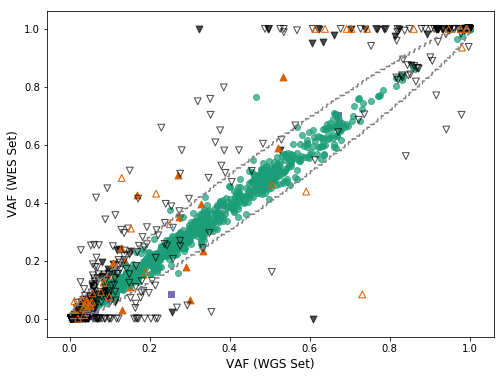

In [56]:
plt.figure(figsize=(8,6))

ms=36

# plt.scatter(0,1, s=ms*1.8, color=unclassifiedColor, marker='1' )
# plt.scatter(0,1, s=ms*1.8, color=lowConfColor,      marker='2' )
# plt.scatter(0,1, s=ms*1.8, color=medConfColor,      marker='+' )
# plt.scatter(0,1, s=ms, color=highConfColor,     marker='x')
# plt.scatter(0,1, s=ms, color='white')

# plt.legend(('Unclassified', 'LowConf', 'MedConf',  'HighConf',  ), fontsize=12, loc='upper left')


plt.scatter(goldset_VAF[ np.all( (snv_unclassified, snvValidated), axis=0 ) ], \
            wes_VAF[     np.all( (snv_unclassified, snvValidated), axis=0 ) ], s=ms*1.3, color=unclassifiedColor, alpha=0.7, marker='v')

plt.scatter(goldset_VAF[ np.all( (snv_lowconf, snvValidated), axis=0 ) ], \
            wes_VAF[     np.all( (snv_lowconf, snvValidated), axis=0 ) ] , s=ms*1.3, color=lowConfColor,  alpha=1, marker='^' )

plt.scatter(goldset_VAF[ np.all( (snv_medconf, snvValidated), axis=0 ) ], \
            wes_VAF[     np.all( (snv_medconf, snvValidated), axis=0 ) ] , s=ms, color=medConfColor,  alpha=1, marker='s' )

plt.scatter(goldset_VAF[ np.all( (snv_highconf, snvValidated), axis=0 ) ], \
            wes_VAF[     np.all( (snv_highconf, snvValidated), axis=0 ) ], s=ms, color=highConfColor, alpha=0.7, marker='o' )




plt.scatter(goldset_VAF[ np.all( (snv_unclassified, snvInvalidated), axis=0 ) ], \
            wes_VAF[     np.all( (snv_unclassified, snvInvalidated), axis=0 ) ], s=ms*1.3, color=unclassifiedColor, alpha=0.7, facecolors='none', marker='v')

plt.scatter(goldset_VAF[ np.all( (snv_lowconf, snvInvalidated), axis=0 ) ], \
            wes_VAF[     np.all( (snv_lowconf, snvInvalidated), axis=0 ) ], s=ms*1.3, color=lowConfColor,  facecolors='none', marker='^')

plt.scatter(goldset_VAF[ np.all( (snv_medconf, snvInvalidated), axis=0 ) ], \
            wes_VAF[     np.all( (snv_medconf, snvInvalidated), axis=0 ) ], s=ms, color=medConfColor,  facecolors='none', marker='s')

plt.scatter(goldset_VAF[ np.all( (snv_highconf, snvInvalidated), axis=0 ) ], \
            wes_VAF[     np.all( (snv_highconf, snvInvalidated), axis=0 ) ], s=ms, color=highConfColor, facecolors='none', marker='o')



# plt.scatter(goldset_VAF[ np.all( (snv_unclassified, snvUnknown), axis=0 ) ], \
#             wes_VAF[     np.all( (snv_unclassified, snvUnknown), axis=0 ) ], s=ms*1.8, color=unclassifiedColor, alpha=0.7, marker='1')

# plt.scatter(goldset_VAF[ np.all( (snv_lowconf, snvUnknown), axis=0 ) ], \
#             wes_VAF[     np.all( (snv_lowconf, snvUnknown), axis=0 ) ], s=ms*1.8, color=lowConfColor,  marker='2')

# plt.scatter(goldset_VAF[ np.all( (snv_medconf, snvUnknown), axis=0 ) ], \
#             wes_VAF[     np.all( (snv_medconf, snvUnknown), axis=0 ) ], s=ms*1.8,  color=medConfColor,  marker='+')

# plt.scatter(goldset_VAF[ np.all( (snv_highconf, snvUnknown), axis=0 ) ], \
#             wes_VAF[     np.all( (snv_highconf, snvUnknown), axis=0 ) ], s=ms, color=highConfColor, marker='x')


x_range     = []
lower_bound = []
upper_bound = []

vaf_i = 0.001
while vaf_i < 1:
    a, b = scipystats.binom.interval(0.95, 100,vaf_i)
    x_range.append(vaf_i)
    lower_bound.append(a/100)
    upper_bound.append(b/100)
    vaf_i += 0.001
    
plt.plot(x_range, lower_bound, color='gray', linestyle = 'dashed')
plt.plot(x_range, upper_bound, color='gray', linestyle = 'dashed')

plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (WES Set)', size=12)

plt.savefig('../Main_Figures/Fig_2f_wes_cross_validation.pdf', bbox_inches='tight')

In [57]:
for conf_i, label_i in zip((snv_highconf, snv_medconf, snv_lowconf, snv_unclassified), ('HighConf', 'MedConf', 'LowConf', 'Unclassified')):
    
    total_i            = sum(conf_i)
    total_validated    = sum(np.all( (conf_i, snvValidated), axis=0 ))
    total_invalidated  = sum(np.all( (conf_i, snvInvalidated), axis=0 ))
    validate_rate      = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i

    totalStats['snv'][label_i]['total']         += total_i
    totalStats['snv'][label_i]['interpretable'] += (total_validated+total_invalidated)
    totalStats['snv'][label_i]['validated']     += total_validated
    totalStats['snv'][label_i]['notValidated']  += total_invalidated

    print('%g %s\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t%.1f%%' % (total_i, label_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate, 100*interpretable_rate*validate_rate) )
    
    
for conf_i, label_i in zip((snv_highconf, snv_medconf, snv_lowconf, snv_unclassified), ('HighConf', 'MedConf', 'LowConf', 'Unclassified')):
    
    total_i            = sum(conf_i)
    total_validated    = sum(np.all( (conf_i, snvValidated), axis=0 ))
    total_invalidated  = sum(np.all( (conf_i, snvInvalidated), axis=0 ))
    validate_rate      = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i
    
    print('%g\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (total_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate , total_validated, total_i, 100*(total_validated/total_i) ))

1089 HighConf	(1088/1089) 99.9%	(1088/1088) 100.0%	99.9%
77 MedConf	(74/77) 96.1%	(74/74) 100.0%	96.1%
422 LowConf	(244/422) 57.8%	(204/244) 83.6%	48.3%
1162 Unclassified	(538/1162) 46.3%	(72/538) 13.4%	6.2%
1089	(1088/1089) 99.9%	(1088/1088) 100.0%	(1088/1089) 99.9%
77	(74/77) 96.1%	(74/74) 100.0%	(74/77) 96.1%
422	(244/422) 57.8%	(204/244) 83.6%	(204/422) 48.3%
1162	(538/1162) 46.3%	(72/538) 13.4%	(72/1162) 6.2%


In [58]:
print( R(goldset_VAF[snv_highconf], wes_VAF[snv_highconf]) )
print( R(goldset_VAF[snv_medconf], wes_VAF[snv_medconf]) )
print( R(goldset_VAF[snv_lowconf], wes_VAF[snv_lowconf]) )
print( R(goldset_VAF[snv_unclassified], wes_VAF[snv_unclassified]) )

0.9966783655856332
0.9869207567642858
0.8887485662570443
0.9047426046372589


In [59]:
tEA1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_EA_T_1.bwa.dedup.bam.txt.gz'
tEA2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_EA_T_2.bwa.dedup.bam.txt.gz'
tFD1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_FD_T_1.bwa.dedup.bam.txt.gz'
tFD2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_FD_T_2.bwa.dedup.bam.txt.gz'
tFD3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_FD_T_3.bwa.dedup.bam.txt.gz'
tIL1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_T_1.bwa.dedup.bam.txt.gz'
tIL2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_T_2.bwa.dedup.bam.txt.gz'
tIL3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_T_3.bwa.dedup.bam.txt.gz'
tIL4 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_T_4.bwa.dedup.bam.txt.gz'
tIL5 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_T_5.bwa.dedup.bam.txt.gz'
tIL6 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_T_6.bwa.dedup.bam.txt.gz'
tLL1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_LL_T_1.bwa.dedup.bam.txt.gz'
tNC1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_NC_T_1.bwa.dedup.bam.txt.gz'
tNV1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_NV_T_1.bwa.dedup.bam.txt.gz'
tNV2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_NV_T_2.bwa.dedup.bam.txt.gz'
tNV3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_NV_T_3.bwa.dedup.bam.txt.gz'

nEA1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_EA_N_1.bwa.dedup.bam.txt.gz'
nEA2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_EA_N_2.bwa.dedup.bam.txt.gz'
nFD1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_FD_N_1.bwa.dedup.bam.txt.gz'
nFD2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_FD_N_2.bwa.dedup.bam.txt.gz'
nFD3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_FD_N_3.bwa.dedup.bam.txt.gz'
nIL1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_N_1.bwa.dedup.bam.txt.gz'
nIL2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_N_2.bwa.dedup.bam.txt.gz'
nIL3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_N_3.bwa.dedup.bam.txt.gz'
nIL4 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_N_4.bwa.dedup.bam.txt.gz'
nIL5 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_N_5.bwa.dedup.bam.txt.gz'
nIL6 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_IL_N_6.bwa.dedup.bam.txt.gz'
nLL1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_LL_N_1.bwa.dedup.bam.txt.gz'
nNC1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_NC_N_1.bwa.dedup.bam.txt.gz'
nNV1 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_NV_N_1.bwa.dedup.bam.txt.gz'
nNV2 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_NV_N_2.bwa.dedup.bam.txt.gz'
nNV3 = '/home/lethalfang/Documents/Bina/SMWG/Manuscript_01_Files/WES/VAF.sINDEL.v1.1.WES_NV_N_3.bwa.dedup.bam.txt.gz'

t_vafFiles = [tEA1, tEA2, tFD1, tFD2, tFD3, tIL1, tIL2, tIL3, tIL4, tIL5, tIL6, tLL1, tNC1, tNV1, tNV2, tNV3]
n_vafFiles = [nEA1, nEA2, nFD1, nFD2, nFD3, nIL1, nIL2, nIL3, nIL4, nIL5, nIL6, nLL1, nNC1, nNV1, nNV2, nNV3]

In [60]:
WesVafs = {}
for file_i in t_vafFiles:
    with genome.open_textfile(file_i) as wes:
        line_i = wes.readline().rstrip()
        line_i = wes.readline().rstrip()
        
        while line_i:
            
            item = line_i.split('\t')
            
            variant_id = (item[0], int(item[1]), item[2], item[3])
            
            if variant_id not in WesVafs:
                WesVafs[variant_id] = {'TDP': [], 'TVarDP': [], 'TVAF': [], 'NDP': [], 'NVarDP': [], 'NVAF': [] }
                
            WesVafs[variant_id]['TDP'].append( int(item[4]) )
            WesVafs[variant_id]['TVarDP'].append( int(item[5]) )
            WesVafs[variant_id]['TVAF'].append( float(item[6]) )
            
            line_i = wes.readline().rstrip()
            

for file_i in n_vafFiles:
    with genome.open_textfile(file_i) as wes:
        line_i = wes.readline().rstrip()
        line_i = wes.readline().rstrip()
        
        while line_i:
            
            item = line_i.split('\t')
            
            variant_id = (item[0], int(item[1]), item[2], item[3])
            
            WesVafs[variant_id]['NDP'].append( int(item[4]) )
            WesVafs[variant_id]['NVarDP'].append( int(item[5]) )
            WesVafs[variant_id]['NVAF'].append( float(item[6]) )
            
            line_i = wes.readline().rstrip()

In [61]:
goldset_VAF = []
wes_VAF     = []

wes_dp        = []
wes_vardp     = []
wes_refdp     = []
n_wes_vardp   = []
n_wes_dp      = []

indel_highconf     = []
indel_medconf      = []
indel_lowconf      = []
indel_unclassified = []

wes_indels         = []

with genome.open_textfile(truth_indel) as superset:
    
    while line_i.startswith('#'):
        line_i = superset.readline().rstrip()
    
    for line_i in superset:
        
        vcf_i = genome.Vcf_line( line_i.rstrip() )
        
        if exome.inRegion( vcf_i.chromosome, vcf_i.position ) and ('ArmLossInNormal' not in vcf_i.info):
            
            variant_id = vcf_i.chromosome, vcf_i.position, vcf_i.refbase, vcf_i.altbase
            wes_indels.append(variant_id)
            
            goldset_VAF.append( float(vcf_i.get_info_value('TVAF')) )
            
            wes_VAF.append( np.median(WesVafs[variant_id]['TVAF'] ) )
            
            wes_dp.append( sum(WesVafs[variant_id]['TDP'] ) )
            wes_vardp.append( sum(WesVafs[variant_id]['TVarDP'] ) )
            
            n_wes_dp.append( sum(WesVafs[variant_id]['NDP'] ) )
            n_wes_vardp.append( sum(WesVafs[variant_id]['NVarDP'] ) )
            
            if re.search(r'HighConf', vcf_i.filters):
                indel_highconf.append( True )
                indel_medconf.append( False )
                indel_lowconf.append( False )
                indel_unclassified.append( False )
                
            elif re.search(r'MedConf', vcf_i.filters):
                indel_highconf.append( False )
                indel_medconf.append( True )
                indel_lowconf.append( False )
                indel_unclassified.append( False )
                
            elif re.search(r'LowConf', vcf_i.filters):
                indel_highconf.append( False )
                indel_medconf.append( False )
                indel_lowconf.append( True )
                indel_unclassified.append( False )
                
            elif re.search(r'Unclassified', vcf_i.filters):
                indel_highconf.append(  False )
                indel_medconf.append( False )
                indel_lowconf.append( False )
                indel_unclassified.append( True )

In [62]:
indel_highconf     = np.array(indel_highconf, dtype=bool)
indel_medconf      = np.array(indel_medconf, dtype=bool)
indel_lowconf      = np.array(indel_lowconf, dtype=bool)
indel_unclassified = np.array(indel_unclassified, dtype=bool)

goldset_VAF   = np.array(goldset_VAF)
wes_VAF       = np.array(wes_VAF)

wes_vardp     = np.array(wes_vardp)
wes_refdp     = np.array(wes_refdp)
wes_dp        = np.array(wes_dp)
n_wes_vardp   = np.array(n_wes_vardp)
n_wes_dp      = np.array(n_wes_dp)

In [63]:
indelValidated = []
indelInvalidated = []
indelUnknown = []

for i, yes in enumerate(wes_VAF):
        
    # Simple rule to decide if validated or not:
    if wes_dp[i] >= 100 and n_wes_dp[i] >= 100:
            
        # VALIDATED
        # If tumor DP low, at least 2 variants. 
        # If tumor DP>50, VAF at least 4% (need more than 2).
        if (wes_vardp[i] >= 32) and (wes_vardp[i]/wes_dp[i] > 10*n_wes_vardp[i]/n_wes_dp[i]):
            indelValidated.append(True)
            indelInvalidated.append(False)
            indelUnknown.append(False)            
            
        # INVALIDATED (Germline Signal)
        elif (n_wes_vardp[i] >= 0.02*n_wes_dp[i]):
            indelValidated.append(False)
            indelInvalidated.append(True)
            indelUnknown.append(False)

        # INVALIDATED (NO variant signal)
        # Expect variant DP >= 10, but gets one or less.
        elif wes_vardp[i] <= 1 and wes_dp[i]*goldset_VAF[i] >= 10:
            indelValidated.append(False)
            indelInvalidated.append(True)
            indelUnknown.append(False)
            
        elif wes_vardp[i] <= 5 and wes_dp[i]*goldset_VAF[i] >= 50:
            indelValidated.append(False)
            indelInvalidated.append(True)
            indelUnknown.append(False)

        # UNKNOWN
        else:
            indelValidated.append(False)
            indelInvalidated.append(False)
            indelUnknown.append(True)

    # UNKNOWN  
    else:
        indelValidated.append(False)
        indelInvalidated.append(False)
        indelUnknown.append(True)

indelValidated   = np.array(indelValidated)
indelInvalidated = np.array(indelInvalidated)
indelUnknown     = np.array(indelUnknown)

In [64]:
for i, variant_i in enumerate(wes_indels):
    
    if variant_i not in validationKeeper:
        validationKeeper[variant_i] = {}
        
    if indel_highconf[i]:
        validationKeeper[variant_i]['confLabel'] = 'HighConf'
    elif indel_medconf[i]:
        validationKeeper[variant_i]['confLabel'] = 'MedConf'
    elif indel_lowconf[i]:
        validationKeeper[variant_i]['confLabel'] = 'LowConf'
    elif indel_unclassified[i]:
        validationKeeper[variant_i]['confLabel'] = 'Unclassified'
    else:
        print(variant_i)
        
    if indelValidated[i]:
        validationKeeper[variant_i]['hiseqWES'] = 'YES'
    elif indelInvalidated[i]:
        validationKeeper[variant_i]['hiseqWES'] = 'NO'
    elif indelUnknown[i]:
        validationKeeper[variant_i]['hiseqWES'] = 'UNKNOWN'
    else:
        print(variant_i)    

In [65]:
validationKeeper[('chr11', 34844360, 'C', 'A')]

{'confLabel': 'LowConf', 'ampliSeq': 'UNKNOWN'}

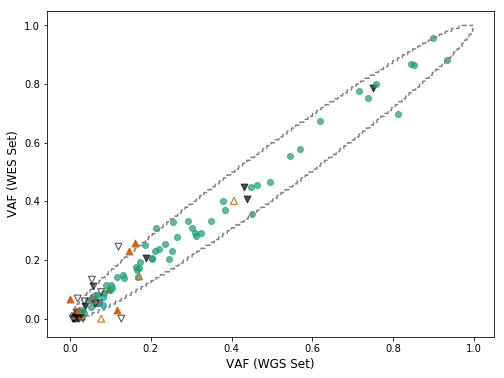

In [66]:
plt.figure(figsize=(8,6))


ms=36

# plt.scatter(0,1, s=ms*1.8, color=unclassifiedColor, marker='1' )
# plt.scatter(0,1, s=ms*1.8, color=lowConfColor,      marker='2' )
# plt.scatter(0,1, s=ms*1.8, color=medConfColor,      marker='+' )
# plt.scatter(0,1, s=ms, color=highConfColor,     marker='x')
# plt.scatter(0,1, s=markersize, color='white')

# plt.legend(('Unclassified', 'LowConf', 'MedConf',  'HighConf',  ), fontsize=12, loc='upper left')


plt.scatter(goldset_VAF[ np.all( (indel_unclassified, indelValidated), axis=0 ) ], \
            wes_VAF[     np.all( (indel_unclassified, indelValidated), axis=0 ) ], s=ms*1.3, color=unclassifiedColor, alpha=0.7, marker='v')

plt.scatter(goldset_VAF[ np.all( (indel_lowconf, indelValidated), axis=0 ) ], \
            wes_VAF[     np.all( (indel_lowconf, indelValidated), axis=0 ) ] , s=ms*1.3, color=lowConfColor,  alpha=1, marker='^' )

plt.scatter(goldset_VAF[ np.all( (indel_medconf, indelValidated), axis=0 ) ], \
            wes_VAF[     np.all( (indel_medconf, indelValidated), axis=0 ) ] , s=ms, color=medConfColor,  alpha=1, marker='s' )

plt.scatter(goldset_VAF[ np.all( (indel_highconf, indelValidated), axis=0 ) ], \
            wes_VAF[     np.all( (indel_highconf, indelValidated), axis=0 ) ], s=ms, color=highConfColor, alpha=0.7, marker='o' )




plt.scatter(goldset_VAF[ np.all( (indel_unclassified, indelInvalidated), axis=0 ) ], \
            wes_VAF[     np.all( (indel_unclassified, indelInvalidated), axis=0 ) ], s=ms*1.3, color=unclassifiedColor, alpha=0.7, facecolors='none', marker='v')

plt.scatter(goldset_VAF[ np.all( (indel_lowconf, indelInvalidated), axis=0 ) ], \
            wes_VAF[     np.all( (indel_lowconf, indelInvalidated), axis=0 ) ], s=ms*1.3, color=lowConfColor,  facecolors='none', marker='^')

plt.scatter(goldset_VAF[ np.all( (indel_medconf, indelInvalidated), axis=0 ) ], \
            wes_VAF[     np.all( (indel_medconf, indelInvalidated), axis=0 ) ], s=ms, color=medConfColor,  facecolors='none', marker='s')

plt.scatter(goldset_VAF[ np.all( (indel_highconf, indelInvalidated), axis=0 ) ], \
            wes_VAF[     np.all( (indel_highconf, indelInvalidated), axis=0 ) ], s=ms, color=highConfColor, facecolors='none', marker='o')




# plt.scatter(goldset_VAF[ np.all( (indel_unclassified, indelUnknown), axis=0 ) ], \
#             wes_VAF[     np.all( (indel_unclassified, indelUnknown), axis=0 ) ], s=ms*1.8, color=unclassifiedColor, alpha=0.7, marker='1')

# plt.scatter(goldset_VAF[ np.all( (indel_lowconf, indelUnknown), axis=0 ) ], \
#             wes_VAF[     np.all( (indel_lowconf, indelUnknown), axis=0 ) ], s=ms*1.8, color=lowConfColor,  marker='2')

# plt.scatter(goldset_VAF[ np.all( (indel_medconf, indelUnknown), axis=0 ) ], \
#             wes_VAF[     np.all( (indel_medconf, indelUnknown), axis=0 ) ], s=ms*1.8,  color=medConfColor,  marker='+')

# plt.scatter(goldset_VAF[ np.all( (indel_highconf, indelUnknown), axis=0 ) ], \
#             wes_VAF[     np.all( (indel_highconf, indelUnknown), axis=0 ) ], s=ms, color=highConfColor, marker='x')


x_range     = []
lower_bound = []
upper_bound = []

vaf_i = 0.001
while vaf_i < 1:
    a, b = scipystats.binom.interval(0.95, 100,vaf_i)
    x_range.append(vaf_i)
    lower_bound.append(a/100)
    upper_bound.append(b/100)
    vaf_i += 0.001
    
plt.plot(x_range, lower_bound, color='gray', linestyle = 'dashed')
plt.plot(x_range, upper_bound, color='gray', linestyle = 'dashed')

plt.xlabel('VAF (WGS Set)', size=12)
plt.ylabel('VAF (WES Set)', size=12)

plt.savefig('../Extended_Data_Figures/Extended_Data_Fig_03c_WES_SNV_CrossValidation.pdf', bbox_inches='tight')

In [67]:
for conf_i, label_i in zip((indel_highconf, indel_medconf, indel_lowconf, indel_unclassified), ('HighConf', 'MedConf', 'LowConf', 'Unclassified')):
    
    total_i            = sum(conf_i)
    total_validated    = sum(np.all( (conf_i, indelValidated), axis=0 ))
    total_invalidated  = sum(np.all( (conf_i, indelInvalidated), axis=0 ))
    validate_rate      = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i

    totalStats['indel'][label_i]['total']         += total_i
    totalStats['indel'][label_i]['interpretable'] += (total_validated+total_invalidated)
    totalStats['indel'][label_i]['validated']     += total_validated
    totalStats['indel'][label_i]['notValidated']  += total_invalidated

    print('%g %s\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t%.1f%%' % (total_i, label_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate, 100*interpretable_rate*validate_rate) )
    
    
for conf_i, label_i in zip((indel_highconf, indel_medconf, indel_lowconf, indel_unclassified), ('HighConf', 'MedConf', 'LowConf', 'Unclassified')):
    
    total_i            = sum(conf_i)
    total_validated    = sum(np.all( (conf_i, indelValidated), axis=0 ))
    total_invalidated  = sum(np.all( (conf_i, indelInvalidated), axis=0 ))
    validate_rate      = total_validated / (total_validated + total_invalidated)
    interpretable_rate = (total_validated + total_invalidated)/total_i
    
    print('%g\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (total_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate , total_validated, total_i, 100*(total_validated/total_i) ))

56 HighConf	(56/56) 100.0%	(56/56) 100.0%	100.0%
3 MedConf	(3/3) 100.0%	(3/3) 100.0%	100.0%
16 LowConf	(14/16) 87.5%	(10/14) 71.4%	62.5%
49 Unclassified	(26/49) 53.1%	(10/26) 38.5%	20.4%
56	(56/56) 100.0%	(56/56) 100.0%	(56/56) 100.0%
3	(3/3) 100.0%	(3/3) 100.0%	(3/3) 100.0%
16	(14/16) 87.5%	(10/14) 71.4%	(10/16) 62.5%
49	(26/49) 53.1%	(10/26) 38.5%	(10/49) 20.4%


In [68]:
print( R(goldset_VAF[indel_highconf], wes_VAF[indel_highconf]) )
print( R(goldset_VAF[indel_medconf], wes_VAF[indel_medconf]) )
print( R(goldset_VAF[indel_lowconf], wes_VAF[indel_lowconf]) )
print( R(goldset_VAF[indel_unclassified], wes_VAF[indel_unclassified]) )

0.9899741062856326
-0.8840962693604557
0.9008669278341128
0.6643007244653949


In [69]:
np.array(wes_indels)[(np.all( (indel_highconf,     indelInvalidated), axis=0 ))]

array([], shape=(0, 4), dtype='<U70')

In [70]:
for variant_i in ampliseqSnvResults:
    if variant_i in ionSnvResults:
        print(variant_i, ionSnvResults[variant_i]['confLabel'], ionSnvResults[variant_i]['Validation'], ampliseqSnvResults[variant_i]['Validation'])

('chr9', 105607844, 'G', 'A') HighConf YES YES
('chr9', 129102404, 'T', 'C') HighConf YES YES
('chr12', 131844177, 'G', 'C') HighConf YES INSPECTION,YES
('chr15', 28815512, 'G', 'A') HighConf NO YES
('chr17', 4545725, 'T', 'C') HighConf YES YES
('chr19', 35488730, 'A', 'C') LowConf YES YES
('chr22', 23875150, 'G', 'A') HighConf YES YES


In [71]:
print('Combined Validation Rates for SNV:')
print('Total\tInterpretable\tValidation Rate')
for conf_i in ('HighConf', 'MedConf', 'LowConf', 'Unclassified'):
    
    total_i            = totalStats['snv'][conf_i]['total']
    total_validated    = totalStats['snv'][conf_i]['validated']
    total_invalidated  = totalStats['snv'][conf_i]['notValidated']
    interpretable_rate = totalStats['snv'][conf_i]['interpretable'] / total_i
    validate_rate      = total_validated / (total_validated + total_invalidated)
    
    print('%g\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (total_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate) )

Combined Validation Rates for SNV:
Total	Interpretable	Validation Rate
2053	(1969/2053) 95.9%	(1962/1969) 99.6%
145	(119/145) 82.1%	(119/119) 100.0%
689	(322/689) 46.7%	(256/322) 79.5%
1716	(670/1716) 39.0%	(93/670) 13.9%


In [72]:
print('Combined Validation Rates for INDEL:')
print('Total\tInterpretable\tValidation Rate')
for conf_i in ('HighConf', 'MedConf', 'LowConf', 'Unclassified'):
    
    total_i            = totalStats['indel'][conf_i]['total']
    total_validated    = totalStats['indel'][conf_i]['validated']
    total_invalidated  = totalStats['indel'][conf_i]['notValidated']
    interpretable_rate = totalStats['indel'][conf_i]['interpretable'] / total_i
    validate_rate      = total_validated / (total_validated + total_invalidated)
    
    print('%g\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (total_i, total_validated+total_invalidated, total_i, 100*interpretable_rate, total_validated, total_validated + total_invalidated, 100*validate_rate) )

Combined Validation Rates for INDEL:
Total	Interpretable	Validation Rate
113	(102/113) 90.3%	(99/102) 97.1%
7	(5/7) 71.4%	(5/5) 100.0%
27	(18/27) 66.7%	(12/18) 66.7%
75	(30/75) 40.0%	(13/30) 43.3%


In [73]:
totalData = { \
              'snv':  {'HighConf':     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                       'MedConf' :     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                       'LowConf' :     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                       'Unclassified': {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                      }, \
              'indel': {'HighConf':     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                        'MedConf' :     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                        'LowConf' :     {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                        'Unclassified': {'total': 0, 'interpretable': 0, 'validated': 0, 'notValidated': 0}, \
                       }, \
             }

In [74]:
snvData = {'HignConf'}
indelData = {}

for variant_i in validationKeeper:
    
    if len(variant_i[2]) == 1 and len(variant_i[3]) == 1:
        vType = 'snv'
    else:
        vType = 'indel'
        
    confLevel_i =  validationKeeper[variant_i]['confLabel']
    totalData[vType][confLevel_i]['total'] += 1
            
    if ('hiseqWES'   in validationKeeper[variant_i] and validationKeeper[variant_i]['hiseqWES']=='YES') or \
       ('ionTorrent' in validationKeeper[variant_i] and validationKeeper[variant_i]['ionTorrent']=='YES') or \
       ('ampliSeq'   in validationKeeper[variant_i] and validationKeeper[variant_i]['ampliSeq']=='YES'):
                
        totalData[vType][confLevel_i]['validated'] += 1
        totalData[vType][confLevel_i]['interpretable'] += 1
        
    elif ('hiseqWES'   in validationKeeper[variant_i] and validationKeeper[variant_i]['hiseqWES']=='NO') or \
         ('ionTorrent' in validationKeeper[variant_i] and validationKeeper[variant_i]['ionTorrent']=='NO') or \
         ('ampliSeq'   in validationKeeper[variant_i] and validationKeeper[variant_i]['ampliSeq']=='NO'):
        
        totalData[vType][confLevel_i]['notValidated'] += 1
        totalData[vType][confLevel_i]['interpretable'] += 1

In [75]:
print('Total unique counts: SNV')

snvTotal         = totalData['snv']['HighConf']['total']         + totalData['snv']['MedConf']['total']
snvInterpretable = totalData['snv']['HighConf']['interpretable'] + totalData['snv']['MedConf']['interpretable']
snvValidated     = totalData['snv']['HighConf']['validated']     + totalData['snv']['MedConf']['validated']
snvVRate         = 100 * snvValidated / snvInterpretable
snvInterRate     = 100 * snvInterpretable / snvTotal
print( '%i\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (snvTotal, snvInterpretable, snvTotal, snvInterRate, snvValidated, snvInterpretable, snvVRate) )


snvTotal         = totalData['snv']['LowConf']['total']         + totalData['snv']['Unclassified']['total']
snvInterpretable = totalData['snv']['LowConf']['interpretable'] + totalData['snv']['Unclassified']['interpretable']
snvValidated     = totalData['snv']['LowConf']['validated']     + totalData['snv']['Unclassified']['validated']
snvVRate         = 100 * snvValidated / snvInterpretable
snvInterRate     = 100 * snvInterpretable / snvTotal

print( '%i\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (snvTotal, snvInterpretable, snvTotal, snvInterRate, snvValidated, snvInterpretable, snvVRate) )

Total unique counts: SNV
1427	(1417/1427) 99.3%	(1416/1417) 99.9%
1669	(854/1669) 51.2%	(314/854) 36.8%


In [76]:
print('Total unique counts: indels')


indelTotal         = totalData['indel']['HighConf']['total']         + totalData['indel']['MedConf']['total']
indelInterpretable = totalData['indel']['HighConf']['interpretable'] + totalData['indel']['MedConf']['interpretable']
indelValidated     = totalData['indel']['HighConf']['validated']     + totalData['indel']['MedConf']['validated']
indelVRate         = 100 * indelValidated / indelInterpretable
indelInterRate     = 100 * indelInterpretable / indelTotal
print( '%i\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (indelTotal, indelInterpretable, indelTotal, indelInterRate, indelValidated, indelInterpretable, indelVRate) )


indelTotal         = totalData['indel']['LowConf']['total']         + totalData['indel']['Unclassified']['total']
indelInterpretable = totalData['indel']['LowConf']['interpretable'] + totalData['indel']['Unclassified']['interpretable']
indelValidated     = totalData['indel']['LowConf']['validated']     + totalData['indel']['Unclassified']['validated']
indelVRate         = 100 * indelValidated / indelInterpretable
indelInterRate     = 100 * indelInterpretable / indelTotal

print( '%i\t(%i/%i) %.1f%%\t(%i/%i) %.1f%%' % (indelTotal, indelInterpretable, indelTotal, indelInterRate, indelValidated, indelInterpretable, indelVRate) )

Total unique counts: indels
80	(78/80) 97.5%	(78/78) 100.0%
69	(42/69) 60.9%	(20/42) 47.6%


In [77]:
import matplotlib
matplotlib.__version__

'3.0.3'